<a href="https://colab.research.google.com/github/sksuman97/TEDed-Talks-views-prediction/blob/main/Capstone_Project_3_Sumanta_Muduli_Ted_Talk_View_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Problem statement-- TED is devoted to spreading powerful ideas on just about any topic. These datasets contain over 4,000 TED talks including transcripts in many languages. Founded in 1984 by Richard Salman as a nonprofit organization that aimed at bringing experts from the fields of Technology, Entertainment, and Design together, TED Conferences have gone on to become the Mecca of ideas from virtually all walks of life. As of 2015, TED and its sister TEDx chapters have published more than 2000 talks for free consumption by the masses and its speaker list boasts of the likes of Al Gore, Jimmy Wales, Shahrukh Khan, and Bill Gates. The main objective is to build a predictive model, which could help in predicting the views of the videos uploaded on the TEDx website.

## Importing Liabraries

In [ ]:
# Importing numpy and pandas
import pandas as pd
import numpy as np

# Importinng matplotlib and seaborn 
import matplotlib.pyplot as plt
import seaborn as sns

# I want to view it difference in days and views in a scaled manner

from sklearn.preprocessing import MinMaxScaler


# Importing train_test_split and grid search cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


# Importing Various regressor algorithms from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
# Importing XGBRegessor from xgboost liabrary
from xgboost import XGBRegressor

# Importing evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error


# Importing warnings liabrary to remove warnings
import warnings
warnings.filterwarnings('ignore')

## Loading data

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Capstone Projects/Ted Talk Views Prediction/Data/data_ted_talks.csv")

# Exploratory Data Analysis

Checking for duplicate rows in dataset

In [ ]:
df.duplicated(['talk_id']).sum()

0

No duplicates found

Removing 'talk_id' column from df as it's of no use

In [ ]:
# del df['talk_id']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         4005 non-null   int64  
 1   title           4005 non-null   object 
 2   speaker_1       4005 non-null   object 
 3   all_speakers    4001 non-null   object 
 4   occupations     3483 non-null   object 
 5   about_speakers  3502 non-null   object 
 6   views           4005 non-null   int64  
 7   recorded_date   4004 non-null   object 
 8   published_date  4005 non-null   object 
 9   event           4005 non-null   object 
 10  native_lang     4005 non-null   object 
 11  available_lang  4005 non-null   object 
 12  comments        3350 non-null   float64
 13  duration        4005 non-null   int64  
 14  topics          4005 non-null   object 
 15  related_talks   4005 non-null   object 
 16  url             4005 non-null   object 
 17  description     4005 non-null   o

Most of the columns are of object type

In [ ]:
df.describe()

talk_id         views     comments     duration
count   4005.000000  4.005000e+03  3350.000000  4005.000000
mean   12432.538327  2.148006e+06   161.997015   724.011236
std    17447.576262  3.451226e+06   268.838922   361.775462
min        1.000000  0.000000e+00     0.000000    60.000000
25%     1252.000000  8.820690e+05    38.000000   393.000000
50%     2333.000000  1.375508e+06    89.000000   738.000000
75%    23777.000000  2.133110e+06   188.000000   974.000000
max    62794.000000  6.505195e+07  6449.000000  3922.000000

## Cleaning Data
* Handling null values in columns

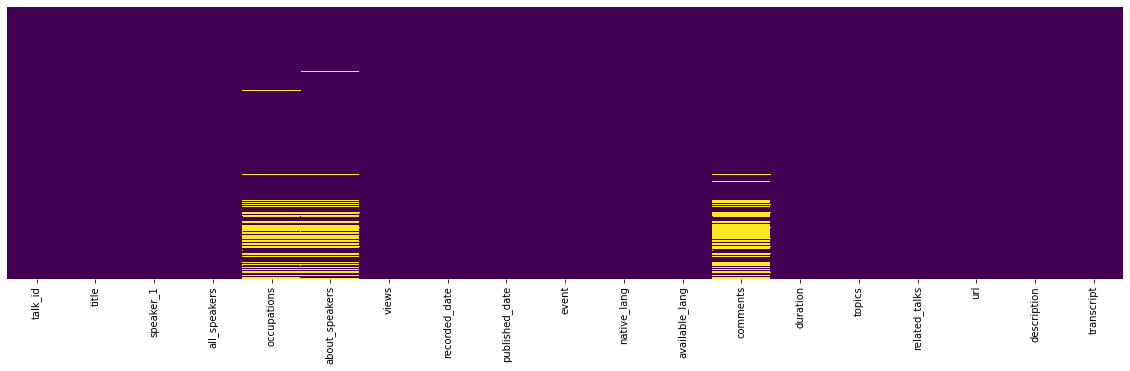

In [ ]:
#checking the missing data in the dataset
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.rcParams['figure.figsize'] = (20, 5)

In [ ]:
# Checking nan values in every column
def nan_check(data):
  '''creating a function that will show percentage of null values in each column'''
  total = data.isnull().sum().sort_values(ascending=False)
  percent_1 = data.isnull().sum()/data.isnull().count()*100
  percent_2 = (np.round(percent_1, 1)).sort_values(ascending=False)
  missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
  return missing_data



In [ ]:
nan_check(df)

In [ ]:
df['views'].max()

65051954

## Related Talks

* **Related_talks column contains a dictionary containing information about six related videos with talk_id as key and video title as it's value.**
* **We can take mean of the views of those six related talks for each video and can add as a new feature called related_views.**

In [ ]:
#applying eval function on available_lang column
df['related_talks'] = df.apply(lambda row: eval(row['related_talks']), axis=1)

In [ ]:
df['related_talks'][0]

{243: 'New thinking on the climate crisis',
 547: 'The business logic of sustainability',
 2093: 'The state of the climate — and what we might do about it',
 2339: "Climate change is happening. Here's how we adapt",
 29968: 'The most important thing you can do to fight climate change: talk about it',
 54715: 'How we can turn the tide on climate'}

In [ ]:
#defining a new feature called related_views
df['related_views'] = 0
#iterating through the each row and extracting the value of related_talks
for index, row in df.iterrows():
    id_list=list(row['related_talks'].keys())
    temp=0
    for i in range(len(df)):
      if (df.loc[i,'talk_id']) in id_list:
        temp+=df.loc[i,'views']

    df.loc[index,'related_views']=temp//6

**Let's plot the related_views column.**

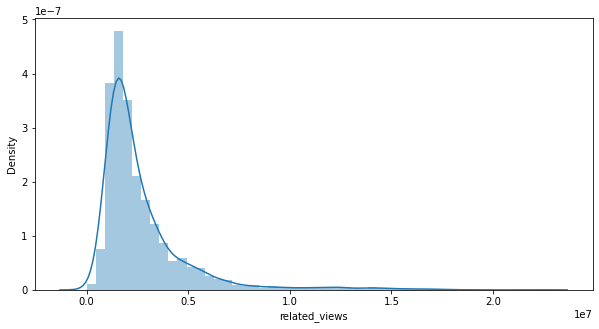

In [ ]:
#Let's plot the related_views column
plt.figure(figsize=(10,5))
sns.distplot(df['related_views'])

* **It's a skewed normal distribution.**

# Imputing the Nan values :

##Numerical-- KNN nan value imputer

Datasets may have missing values, and this can cause problems for many machine learning algorithms.

As such, it is good practice to identify and replace missing values for each column in your input data prior to modeling your prediction task. This is called missing data imputation, or imputing for short.

A popular approach to missing data imputation is to use a model to predict the missing values. This requires a model to be created for each input variable that has missing values. Although any one among a range of different models can be used to predict the missing values, the k-nearest neighbor (KNN) algorithm has proven to be generally effective, often referred to as “nearest neighbor imputation.”

In [ ]:
df.head(1)

talk_id  ... related_views
0        1  ...       1659584

[1 rows x 20 columns]

In [ ]:
numerical_features= ['duration','comments']

In [ ]:
# Before applying KNNImputer, we have to scale features so avoid bias.
scaler = MinMaxScaler()


#Import libraries
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer()

#fitting the model
imputer.fit(scaler.fit_transform(df[numerical_features]))

# transform the dataset
df[numerical_features] = imputer.transform(scaler.fit_transform(df[numerical_features]))

In [ ]:
df.head(1)

talk_id  ... related_views
0        1  ...       1659584

[1 rows x 20 columns]

In [ ]:
nan_check(df)

Total     %
occupations       522  13.0
about_speakers    503  12.6
all_speakers        4   0.1
recorded_date       1   0.0
related_views       0   0.0
transcript          0   0.0
title               0   0.0
speaker_1           0   0.0
views               0   0.0
published_date      0   0.0
event               0   0.0
native_lang         0   0.0
available_lang      0   0.0
comments            0   0.0
duration            0   0.0
topics              0   0.0
related_talks       0   0.0
url                 0   0.0
description         0   0.0
talk_id             0   0.0

All the nan values for numerical features is removed.

## Categorical features-- nan values are labelled as 'Unkwown'

In [ ]:
#categorical features 

categorical_features= ['title','speaker_1','all_speakers','event','native_lang','available_lang','topics','related_talks','url','description','transcript','occupations','about_speakers']

In [ ]:
df[categorical_features]=df[categorical_features].fillna('Unknown')

The Recorded date is having null date but in string format. I would like to replace it with first value.

In [ ]:
#First value

df['recorded_date'][0]

'2006-02-25'

In [ ]:
df['recorded_date']=df['recorded_date'].fillna('2006-02-25')

In [ ]:
nan_check(df)

Total    %
related_views       0  0.0
transcript          0  0.0
title               0  0.0
speaker_1           0  0.0
all_speakers        0  0.0
occupations         0  0.0
about_speakers      0  0.0
views               0  0.0
recorded_date       0  0.0
published_date      0  0.0
event               0  0.0
native_lang         0  0.0
available_lang      0  0.0
comments            0  0.0
duration            0  0.0
topics              0  0.0
related_talks       0  0.0
url                 0  0.0
description         0  0.0
talk_id             0  0.0

## I have taken care of all null values.

#Extensive analysis on each of the features.

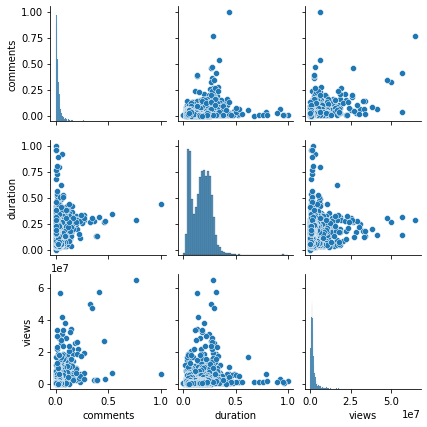

In [ ]:
sns.pairplot(df[['comments', 'duration','views']],  size=2)
plt.show()

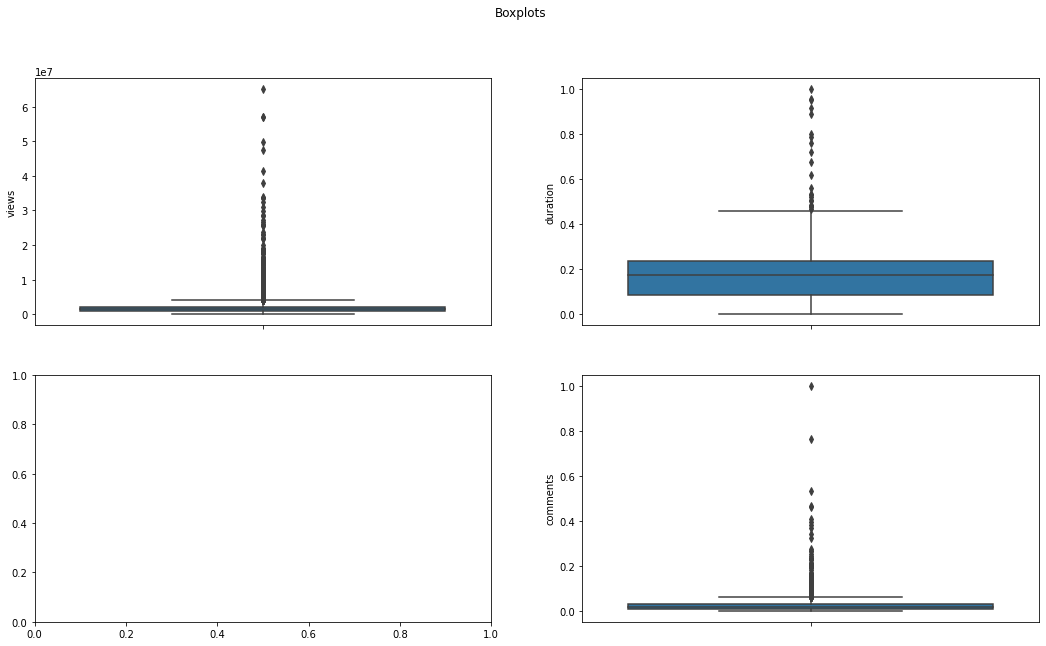

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(18, 10))

fig.suptitle('Boxplots')

sns.boxplot(ax=axes[0, 0], data=df, y='views')
sns.boxplot(ax=axes[0, 1], data=df,  y='duration')
sns.boxplot(ax=axes[1,1], data=df, y='comments')

Many outliers are there

## Distibution of variables

There are also positvie and negative infinity values on views. Converting them to maximum and nan respectively.

In [ ]:

# Replacing infinite with nan
df['views'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Replacing zero with nan
df['views']=np.where(df['views']==0,np.nan,df['views'])
  
# Dropping all the rows with nan values
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 0 to 4003
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         3999 non-null   int64  
 1   title           3999 non-null   object 
 2   speaker_1       3999 non-null   object 
 3   all_speakers    3999 non-null   object 
 4   occupations     3999 non-null   object 
 5   about_speakers  3999 non-null   object 
 6   views           3999 non-null   float64
 7   recorded_date   3999 non-null   object 
 8   published_date  3999 non-null   object 
 9   event           3999 non-null   object 
 10  native_lang     3999 non-null   object 
 11  available_lang  3999 non-null   object 
 12  comments        3999 non-null   float64
 13  duration        3999 non-null   float64
 14  topics          3999 non-null   object 
 15  related_talks   3999 non-null   object 
 16  url             3999 non-null   object 
 17  description     3999 non-null   o

In [ ]:
df.describe()

talk_id         views     comments     duration  related_views
count   3999.000000  3.999000e+03  3999.000000  3999.000000   3.999000e+03
mean   12391.567392  2.151228e+06     0.024227     0.171946   2.731040e+06
std    17417.870986  3.452810e+06     0.038531     0.093705   2.311997e+06
min        1.000000  1.000400e+04     0.000000     0.000000   0.000000e+00
25%     1250.500000  8.841345e+05     0.006823     0.086095   1.422125e+06
50%     2330.000000  1.376590e+06     0.014576     0.175557   1.989402e+06
75%    23766.000000  2.135049e+06     0.028004     0.236665   3.144400e+06
max    62784.000000  6.505195e+07     1.000000     1.000000   2.233165e+07

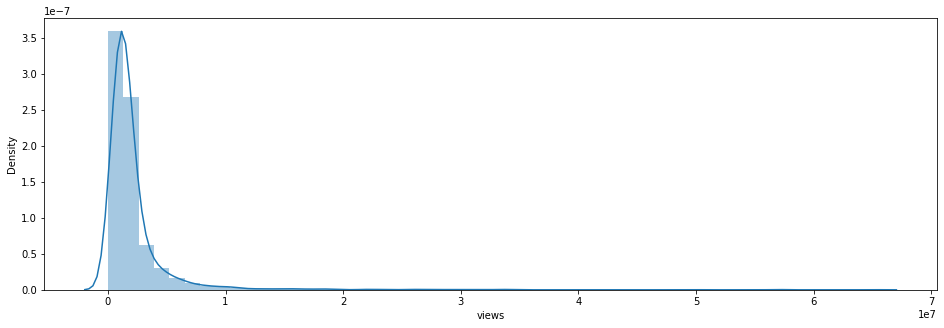

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.distplot(df['views'], ax=ax)

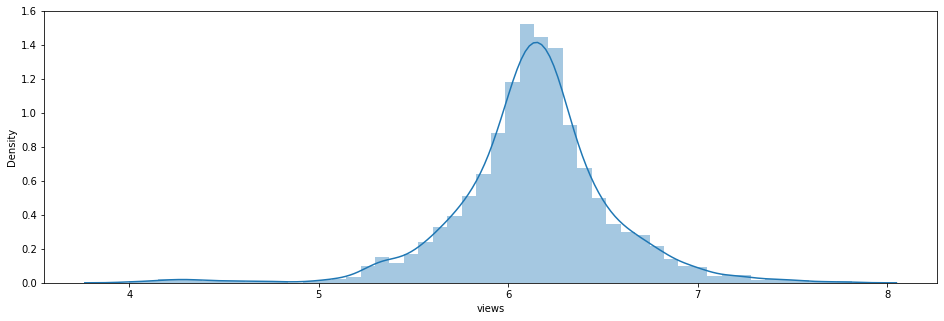

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.distplot(np.log10(df['views']), ax=ax)

Right Skewed 

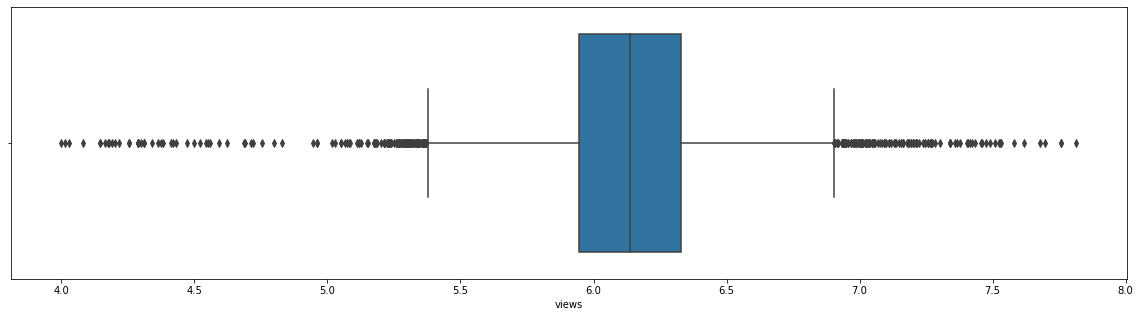

In [ ]:
sns.boxplot(np.log10(df['views']))

In [ ]:
# Applying log transformation in views column
df['views']=np.log10(df['views'])

Target variable is now in perfect normal shape

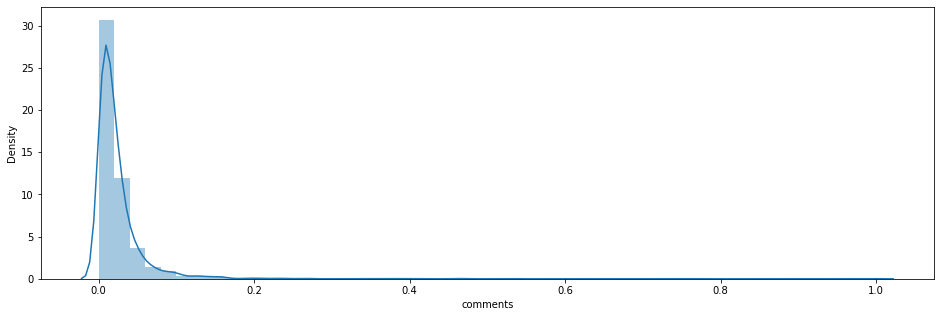

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.distplot(df['comments'],ax=ax)

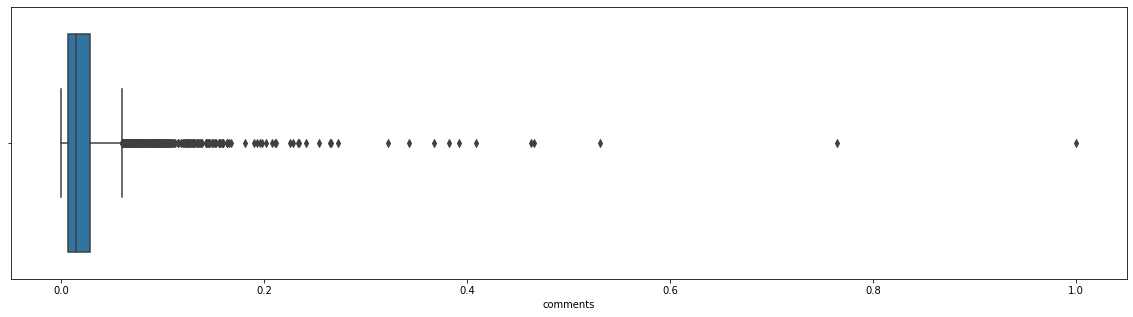

In [ ]:
sns.boxplot(df['comments'])

In [ ]:
df['comments'].value_counts()

0.001861    35
0.002326    33
0.007443    31
0.002171    30
0.003722    30
            ..
0.024500     1
0.142503     1
0.071639     1
0.158164     1
1.000000     1
Name: comments, Length: 813, dtype: int64

Right skewed

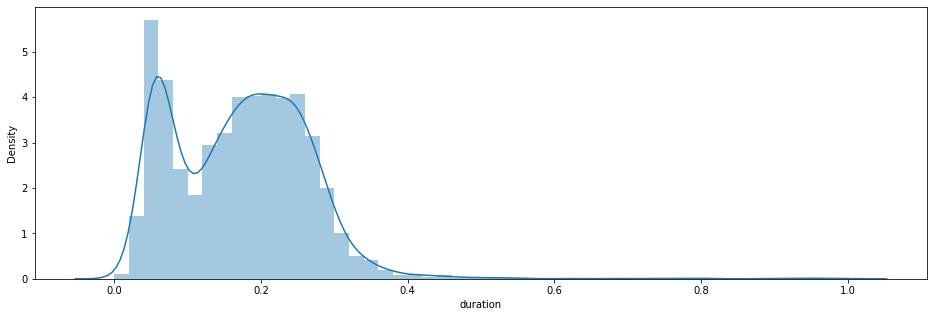

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.distplot(df['duration'],ax=ax)

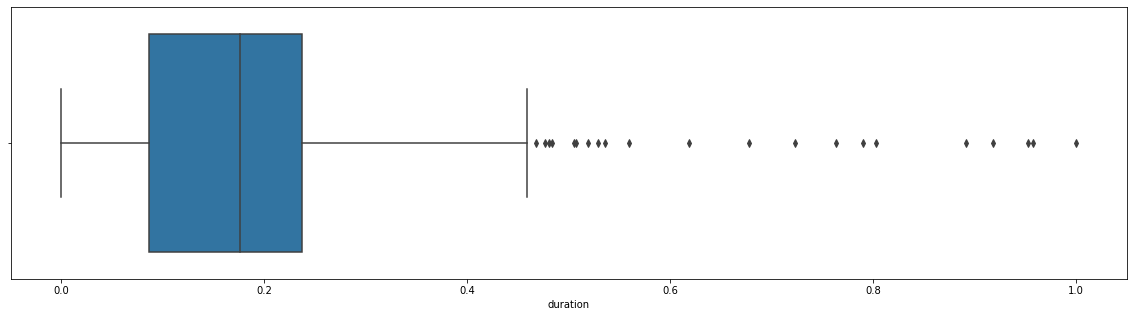

In [ ]:
sns.boxplot(df['duration'])

## Counting number of outliers in a column

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1


((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

about_speakers      0
all_speakers        0
available_lang      0
comments          301
description         0
duration           21
event               0
native_lang         0
occupations         0
published_date      0
recorded_date       0
related_talks       0
related_views     300
speaker_1           0
talk_id           118
title               0
topics              0
transcript          0
url                 0
views             272
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 0 to 4003
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         3999 non-null   int64  
 1   title           3999 non-null   object 
 2   speaker_1       3999 non-null   object 
 3   all_speakers    3999 non-null   object 
 4   occupations     3999 non-null   object 
 5   about_speakers  3999 non-null   object 
 6   views           3999 non-null   float64
 7   recorded_date   3999 non-null   object 
 8   published_date  3999 non-null   object 
 9   event           3999 non-null   object 
 10  native_lang     3999 non-null   object 
 11  available_lang  3999 non-null   object 
 12  comments        3999 non-null   float64
 13  duration        3999 non-null   float64
 14  topics          3999 non-null   object 
 15  related_talks   3999 non-null   object 
 16  url             3999 non-null   object 
 17  description     3999 non-null   o

In [ ]:
# Replacing outliers with extreme values

for i in ['comments','duration','views']:
  Q1 = df[i].quantile(0.25)
  Q3 = df[i].quantile(0.75)
  IQR = Q3 - Q1

  df[i]=np.where(df[i]<(Q1 - 1.5 * IQR),(Q1 - 1.5 * IQR),np.where(df[i]>(Q3 + 1.5 * IQR),(Q3 + 1.5 * IQR),df[i]))
  # df[i]=np.where(df[i]>(Q3 - 1.5 * IQR),(Q3 + 1.5 * IQR),df[i])

In [ ]:
df.head()

talk_id  ... related_views
0        1  ...       1659584
1       92  ...       1573950
2        7  ...       3051136
3       53  ...       1053294
4       66  ...       5517750

[5 rows x 20 columns]

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1


((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

about_speakers      0
all_speakers        0
available_lang      0
comments            0
description         0
duration            0
event               0
native_lang         0
occupations         0
published_date      0
recorded_date       0
related_talks       0
related_views     300
speaker_1           0
talk_id           118
title               0
topics              0
transcript          0
url                 0
views               0
dtype: int64

## Finally there is no outliers in dependent and independent columns.

In [ ]:
df.head()

talk_id  ... related_views
0        1  ...       1659584
1       92  ...       1573950
2        7  ...       3051136
3       53  ...       1053294
4       66  ...       5517750

[5 rows x 20 columns]

##I wanna take a look at what are the year,months and days that most of these ted talks have taken place.

First for the published dates: get the time stamps.

In [ ]:
import time

In [ ]:
import datetime

In [ ]:
df['published_date'] = df['published_date'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))

In [ ]:
df['published_day'] = df['published_date'].apply(lambda x: x.weekday())
df['published_month'] = df['published_date'].apply(lambda x: x.month)
df['published_year'] = df['published_date'].apply(lambda x: x.year)

###For the recorded date now:

In [ ]:
df['recorded_date'] = df['recorded_date'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))

In [ ]:
df['recorded_day'] = df['recorded_date'].apply(lambda x: x.weekday())
df['recorded_month'] = df['recorded_date'].apply(lambda x: x.month)
df['recorded_year'] = df['recorded_date'].apply(lambda x: x.year)

## I also want to keep the number of days it takes between recording and publishing.

In [ ]:
df['diff_record_publish']= df['published_date']- df['recorded_date']

In [ ]:
df['diff_record_publish'] = pd.to_numeric(df['diff_record_publish'].dt.days, downcast='integer')

## Age of the video:

In [ ]:
current_date= datetime.datetime(2021,5,18)

In [ ]:
df['age_of_video']= current_date.year- df['published_year']

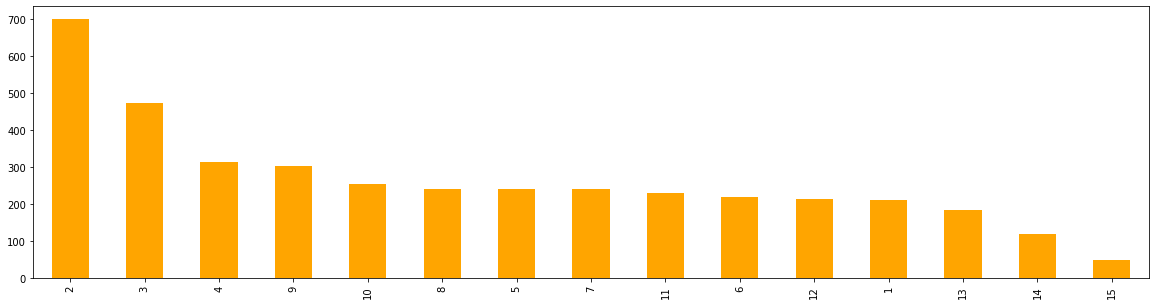

In [ ]:
#Plotting the age of most videos

df['age_of_video'].value_counts().sort_values(ascending=False).plot(kind='bar', color= 'orange')

There is a sharp hike in the number of videos published in past 3 years which is showing the how TED talks have gained popularity in last years.



Determining the relationship of age of video with the views:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 0 to 4003
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   talk_id              3999 non-null   int64         
 1   title                3999 non-null   object        
 2   speaker_1            3999 non-null   object        
 3   all_speakers         3999 non-null   object        
 4   occupations          3999 non-null   object        
 5   about_speakers       3999 non-null   object        
 6   views                3999 non-null   float64       
 7   recorded_date        3999 non-null   datetime64[ns]
 8   published_date       3999 non-null   datetime64[ns]
 9   event                3999 non-null   object        
 10  native_lang          3999 non-null   object        
 11  available_lang       3999 non-null   object        
 12  comments             3999 non-null   float64       
 13  duration             3999 non-nul

Text(0.5, 1.0, 'Number of days between recording and publishing')

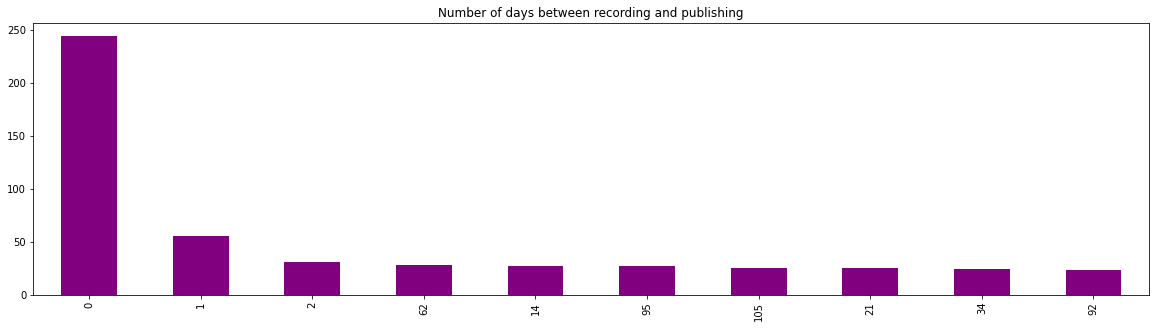

In [ ]:
#plotting these to get a better idea

df['diff_record_publish'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar',color='purple')

plt.title('Number of days between recording and publishing')

Most of videos are published on the same day of recording.

# Find the dependence of views on the difference in recorded and published days:

In [ ]:
df['diff_record_publish'] = MinMaxScaler().fit_transform(np.array(df['diff_record_publish']).reshape(-1,1))

In [ ]:
# df['views'] = MinMaxScaler().fit_transform(np.array(df['views']).reshape(-1,1))

In [ ]:
df.head()

talk_id                            title  ... diff_record_publish age_of_video
0        1      Averting the climate crisis  ...            0.074611           15
1       92  The best stats you've ever seen  ...            0.074931           15
2        7                 Simplicity sells  ...            0.074718           15
3       53              Greening the ghetto  ...            0.074504           15
4       66      Do schools kill creativity?  ...            0.074611           15

[5 rows x 28 columns]

In [ ]:
df['diff_record_publish'].value_counts()

0.061607    244
0.061714     55
0.061821     31
0.068216     28
0.063100     27
           ... 
0.297271      1
0.099019      1
0.179386      1
0.264016      1
1.000000      1
Name: diff_record_publish, Length: 926, dtype: int64

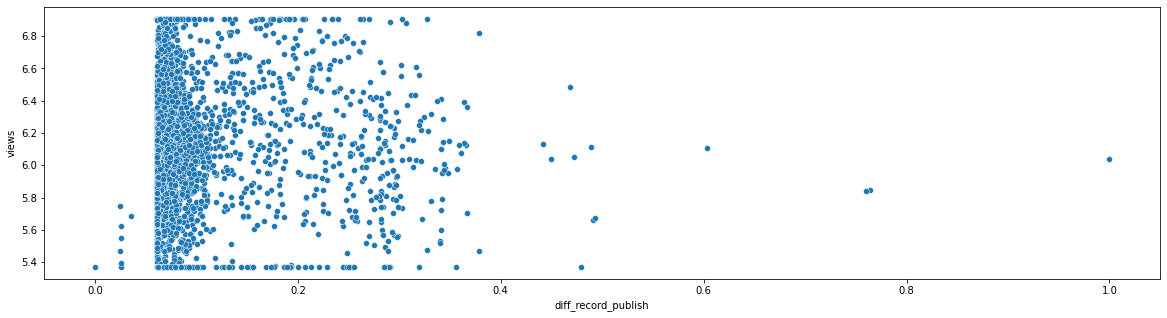

In [ ]:
sns.scatterplot(x= df['diff_record_publish'], y=df['views'])

In [ ]:
df.head(3)

talk_id                            title  ... diff_record_publish age_of_video
0        1      Averting the climate crisis  ...            0.074611           15
1       92  The best stats you've ever seen  ...            0.074931           15
2        7                 Simplicity sells  ...            0.074718           15

[3 rows x 28 columns]

## I want to determine the most popular days,months and year of publishing:

## Looking for the most popular days for the publishing views.

In [ ]:
df['published_day']=df['published_day'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

Text(0.5, 1.0, 'Published Days')

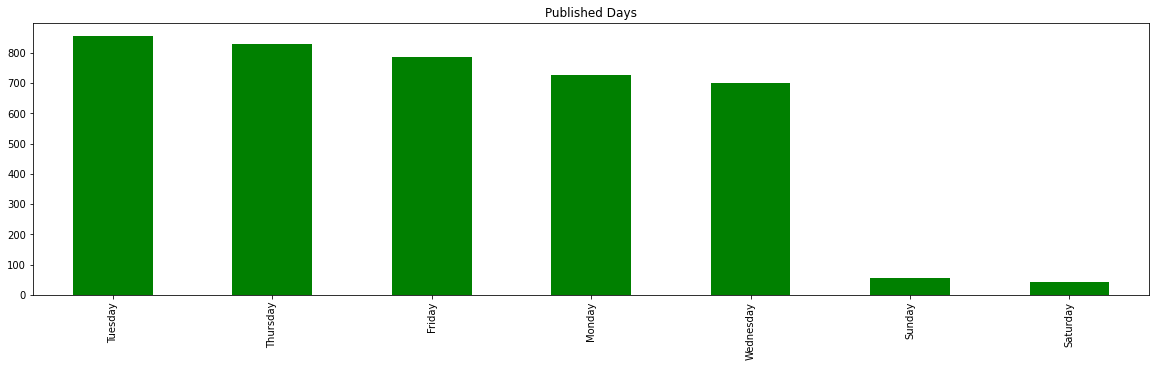

In [ ]:
df['published_day'].value_counts().sort_values(ascending=False).plot(kind='bar', color='g')

plt.title('Published Days')

## Very less number of videos are published on weekend than other regular days.

## Frequency encoding:

In [ ]:
#Frequency encoding

enc_nom_1 = (df.groupby('published_day').size()) / len(df)

df['published_day_encode'] = df['published_day'].apply(lambda x : enc_nom_1[x])

In [ ]:
df.drop(columns='published_day',inplace= True)

## Most published months:


In [ ]:
df['published_month']=df['published_month'].map({1:'Jan',2:'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})


Text(0.5, 1.0, 'Published Months')

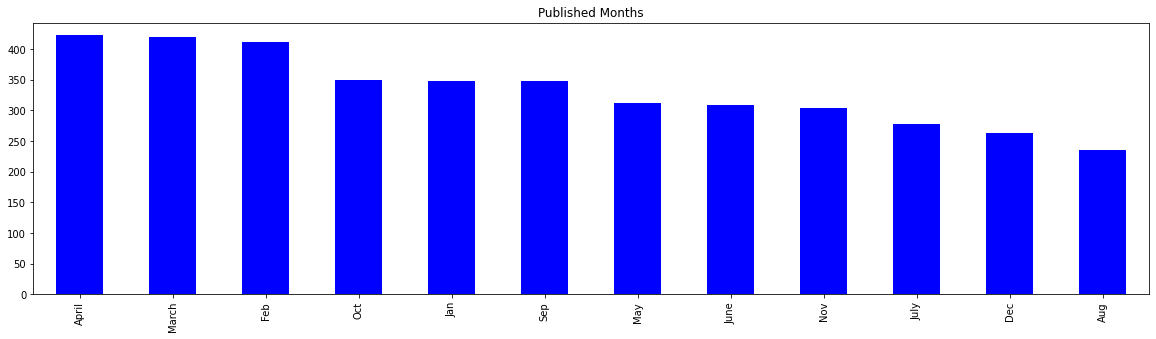

In [ ]:
df['published_month'].value_counts().sort_values(ascending=False).plot(kind='bar', color='blue')

plt.title('Published Months')

## Number of videos pulished on April,March, Feb are higher than other months while less number of videos are published on Dec and Aug.

In [ ]:
#Frequency encoding

enc_nom_1 = (df.groupby('published_month').size()) / len(df)

df['published_month_encode'] = df['published_month'].apply(lambda x : enc_nom_1[x])

In [ ]:
df.drop(columns='published_month',inplace= True)

## Most published year:

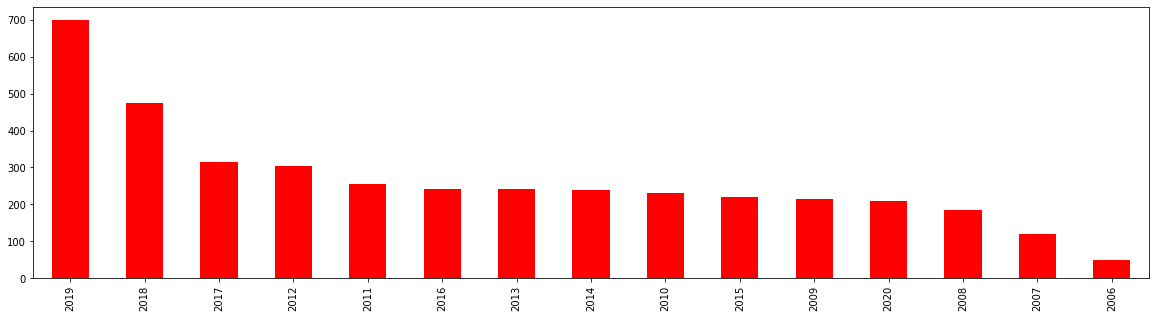

In [ ]:
df['published_year'].value_counts().sort_values(ascending=False).plot(kind='bar', color='r')

# Most popular recorded day, month and year:

## Recorded days distribution:

In [ ]:
df['recorded_day']=df['recorded_day'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

Text(0.5, 1.0, 'Recorded Days')

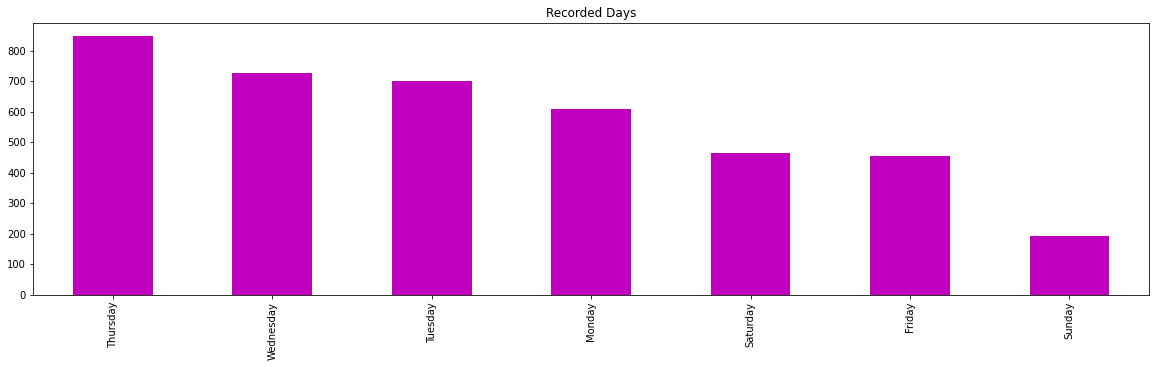

In [ ]:
df['recorded_day'].value_counts().sort_values(ascending=False).plot(kind='bar', color='m')

plt.title('Recorded Days')

## Very few videos are recorded on Sunday.

## Frequency encoding :

In [ ]:
#Frequency encoiding

enc_nom_1 = (df.groupby('recorded_day').size()) / len(df)

df['recorded_day_encode'] = df['recorded_day'].apply(lambda x : enc_nom_1[x])

In [ ]:
df.drop(columns= 'recorded_day',inplace= True)

## Monthly Recorded distribution:

In [ ]:
df['recorded_month']=df['recorded_month'].map({1:'Jan',2:'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

Text(0.5, 1.0, 'Recorded Months')

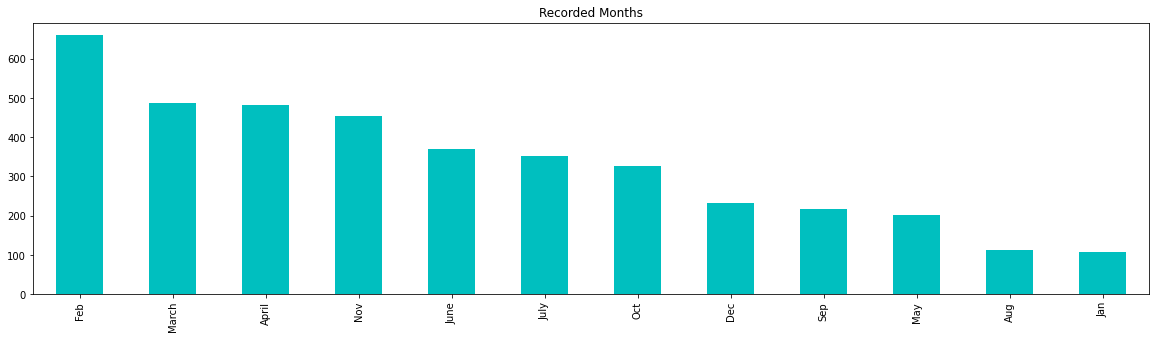

In [ ]:
df['recorded_month'].value_counts().sort_values(ascending=False).plot(kind='bar', color='c')

plt.title('Recorded Months')

Few number of videos are recorded in January and August month where it's highest in February.

## Frequency encoding:


In [ ]:
#Frequency encoiding

enc_nom_1 = (df.groupby('recorded_month').size()) / len(df)

df['recorded_month_encode'] = df['recorded_month'].apply(lambda x : enc_nom_1[x])

In [ ]:
df.drop(columns= 'recorded_month',inplace= True)

## Most recorded year:

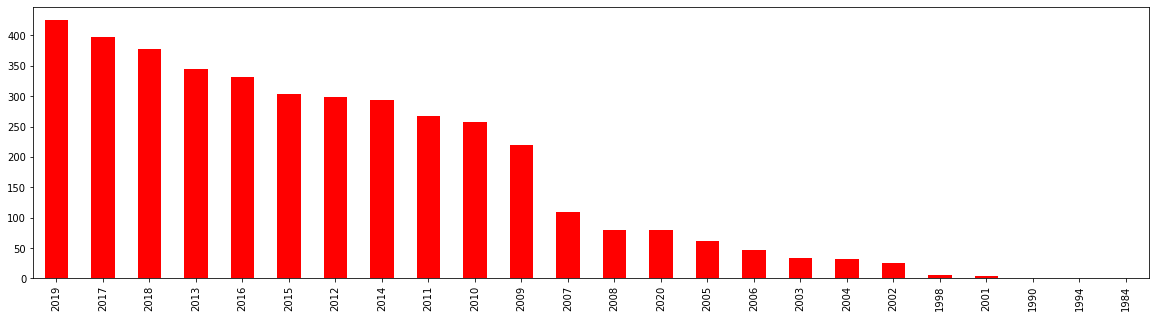

In [ ]:
df['recorded_year'].value_counts().sort_values(ascending=False).plot(kind='bar', color='r')

# We can drop the following columns:

1.  URL- we aren't doing any SEO so doesn't seem important

2. published and recorded date- we have already taken care of these non numerical columns.

In [ ]:
df.drop(columns=['url','recorded_date','published_date'],inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 0 to 4003
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   talk_id                 3999 non-null   int64  
 1   title                   3999 non-null   object 
 2   speaker_1               3999 non-null   object 
 3   all_speakers            3999 non-null   object 
 4   occupations             3999 non-null   object 
 5   about_speakers          3999 non-null   object 
 6   views                   3999 non-null   float64
 7   event                   3999 non-null   object 
 8   native_lang             3999 non-null   object 
 9   available_lang          3999 non-null   object 
 10  comments                3999 non-null   float64
 11  duration                3999 non-null   float64
 12  topics                  3999 non-null   object 
 13  related_talks           3999 non-null   object 
 14  description             3999 non-null   

# Number of languages: 

First convert the string to list:

In [ ]:
#Function to use eval function to convert string to list.
def convert_string_to_original_dtype(x):
  return eval(x)

In [ ]:
df['available_lang']= df['available_lang'].apply(convert_string_to_original_dtype)

Create another feature that has the count of these languages:

In [ ]:
#Function to calculate the count of languages

def length(x):
  return len(x)

In [ ]:
df['count_available_lang']= df['available_lang'].apply(length)

Let us see the distribution now:

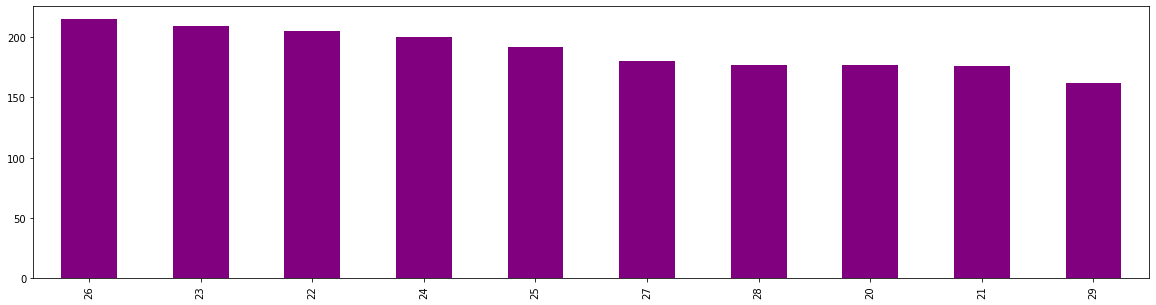

In [ ]:
#Distribution of the top 10 counts of languages

df['count_available_lang'].value_counts().sort_values(ascending= False).head(10).plot(kind= 'bar',color= 'purple')


Most ted talks are available in 20-30 languages.

Now that I have the count of languages in a numerical format, I can drop the available languages column.

In [ ]:
#dropping the available languages

df.drop(columns='available_lang',inplace= True)

## Native Languages:

In [ ]:
#Looking at the unique values first

df['native_lang'].unique()

array(['en', 'fr', 'de', 'pt', 'ko', 'zh-cn', 'ar', 'pt-br', 'es', 'ja',
       'it', 'hi'], dtype=object)

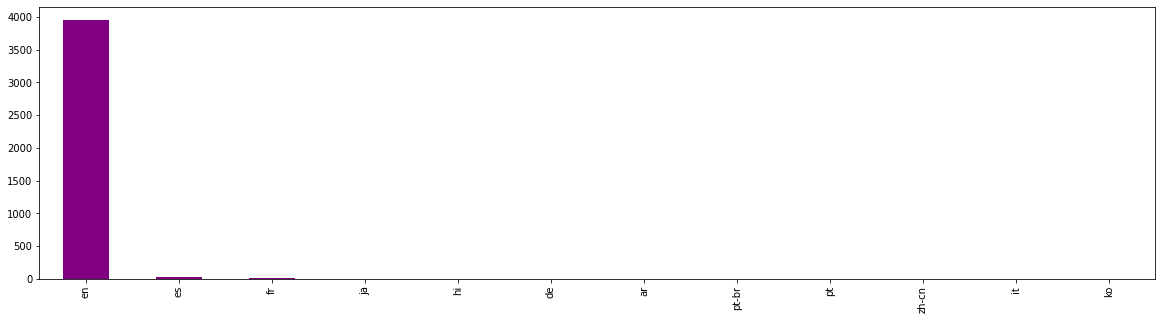

In [ ]:
#The distribution:

df['native_lang'].value_counts().plot(kind='bar',color='purple')

Around 3950 are available in English and around only 50 in other languages. This will not result in any difference in the views because of the 5% difference and mostly is a homogenous column.

I will therefore drop this to not further increase the complexity.

In [ ]:
df.drop(columns='native_lang',inplace= True)

## Event:

In [ ]:
df['event'][0]

'TED2006'

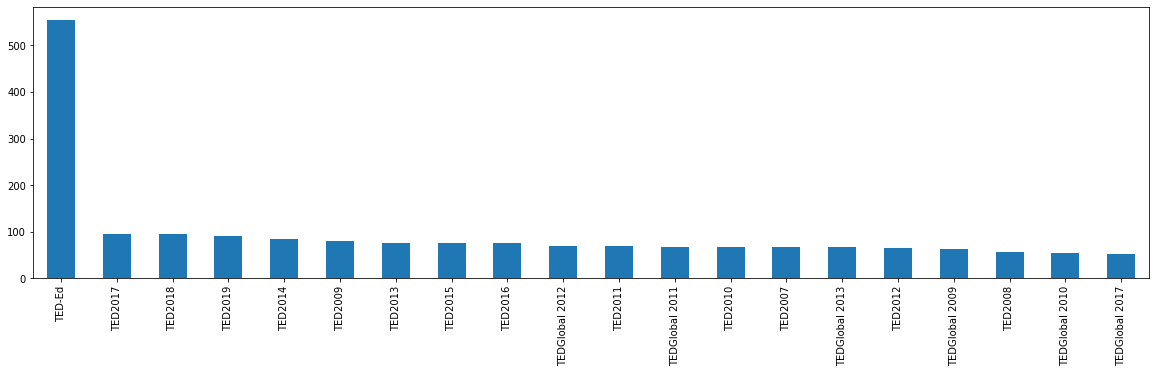

In [ ]:
df['event'].value_counts().sort_values(ascending= False).head(20).plot(kind= 'bar')

The Ted-Ed  being the one with the highest medium gives us a idea that 

---

knowledge sharing and academics is a very popular kind of medium.

## Frequency Encoding-

In [ ]:
enc_nom_1 = (df.groupby('event').size()) / len(df)

df['event_encode'] = df['event'].apply(lambda x : enc_nom_1[x])

In [ ]:
df.drop(columns= 'event',inplace =True)

## Number of Speakers:

 This column will help retain the speakers :

In [ ]:
df['all_speakers'][0]

"{0: 'Al Gore'}"

Function for converting:

In [ ]:
#This function converts string to dict:
def convert_string_to_dict(x):
  if x== 'Unknown':
    pass
  else:
    return eval(x)

In [ ]:
df['all_speakers']=df['all_speakers'].apply(convert_string_to_dict)

In [ ]:
df['all_speakers'][0]

{0: 'Al Gore'}

Next I want to get speakers in a series format and not in a dictionary format. And the count of speakers in each talk.

In [ ]:
len(df['all_speakers'][0])

1

In [ ]:
#function to obtain the count of speakers

def get_count_speakers(x):
  try:
    return len(x)
  except TypeError:
    return 0


In [ ]:
df['count_of_speakers']= df['all_speakers'].apply(get_count_speakers)

Text(0.5, 1.0, 'Count of Speakers')

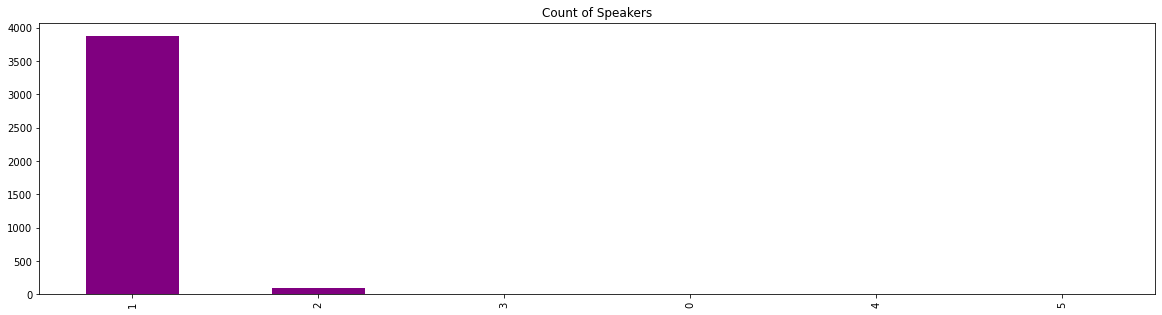

In [ ]:
df['count_of_speakers'].value_counts().plot(kind='bar',color='purple')

plt.title('Count of Speakers')

Except a few, most have 1 speaker in the talks.

In [ ]:
#function to get a separate column for the speakers only

def get_speakers(x):
  speakers=[]
  try:
    for key,value in x.items():
      speakers.append(value)
  except AttributeError:
    speakers.append('Unknown')
  return speakers


In [ ]:
df['Speakers']= df['all_speakers'].apply(get_speakers)

Let us see who are the speakers :

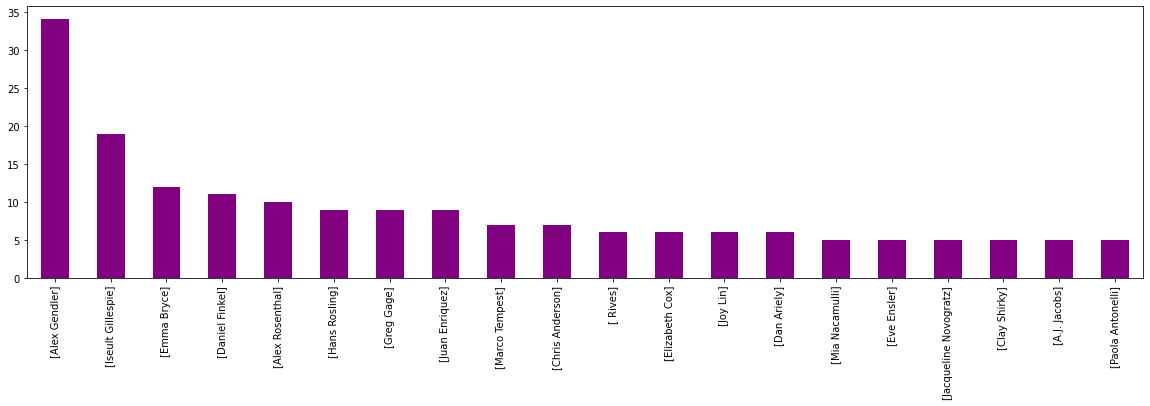

In [ ]:
df['Speakers'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar',color='purple')

Comparing views with number of speakers:

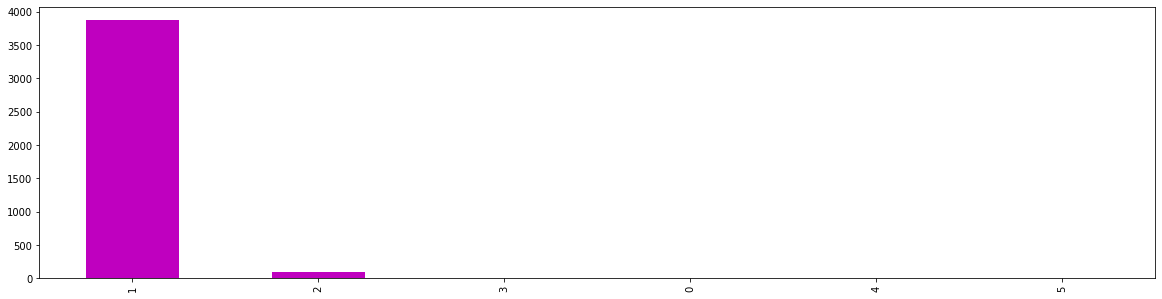

In [ ]:
df['count_of_speakers'].value_counts().plot(kind='bar',color='m')

We can infer from here that, one speaker is enough for views if he popular enough and not needed for two speakers

As Speakers_1 is very similar to all_Speakers

In [ ]:
df.drop(columns=['all_speakers','count_of_speakers','Speakers'],inplace= True)

## Speaker 1:

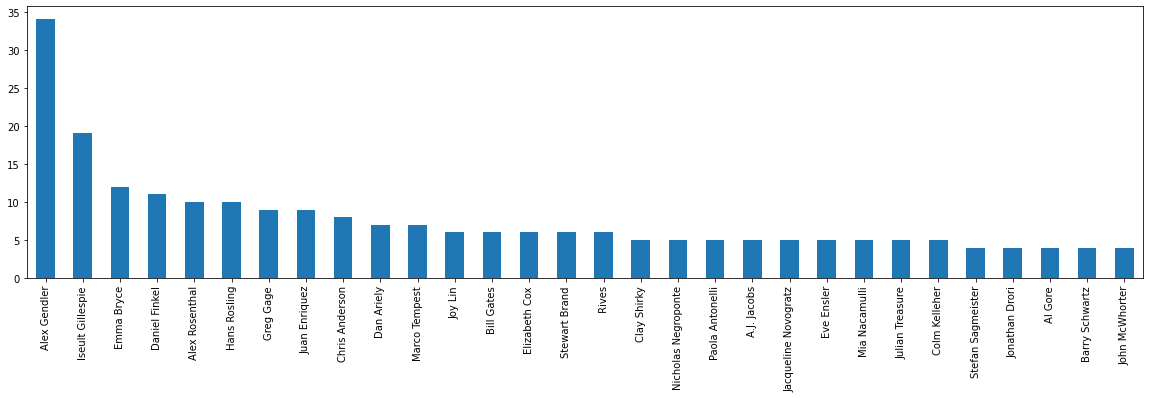

In [ ]:
df['speaker_1'].value_counts().sort_values(ascending= False).head(30).plot(kind='bar')

## Encoding by Frequency Encoding:

In [ ]:
enc_nom_1 = (df.groupby('speaker_1').size()) / len(df)


df['speaker_1_encode'] = df['speaker_1'].apply(lambda x : enc_nom_1[x])


## Dropping the speaker 1 feature then:

In [ ]:
df.drop(columns='speaker_1',inplace= True)

## Occupation:

In [ ]:
df['occupations'][0]

"{0: ['climate advocate']}"

In [ ]:
df['occupations']=df['occupations'].apply(convert_string_to_dict)

In [ ]:
#Function to convert list to string
def list_to_string(x):
  for item in x:
    return item

In [ ]:
#Function to obtain occupation 

def get_occupation(x):
  try:
    for key,value in x.items():
      return value
  except AttributeError:
    return 'Unknown'



In [ ]:
df['occupation']= df['occupations'].apply(get_occupation)

In [ ]:
df['occupation'][0]

['climate advocate']

In [ ]:
df['occupation']= df['occupation'].apply(list_to_string)

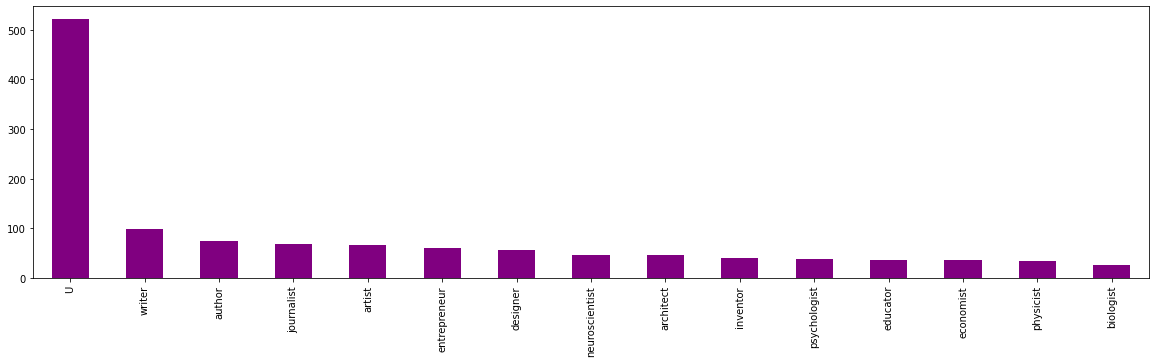

In [ ]:
#Plot the occupations plot

df['occupation'].value_counts().head(15).plot(kind='bar',color= 'purple')

A lot of these values are given as 'U'. Let me understand these values first.

In [ ]:
df[df['occupation']=='U'].head(3)

talk_id  ... occupation
1142     1407  ...          U
1170     1436  ...          U
1241     1515  ...          U

[3 rows x 24 columns]

Most of the U values are given for None type occupations. I will be changing them to not available.

In [ ]:
df['occupation']=df['occupation'].replace(['U'],'Not available')

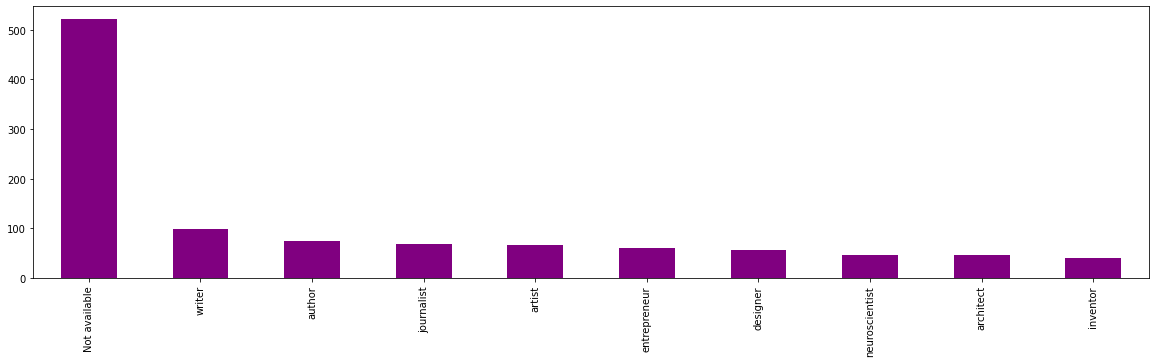

In [ ]:
df['occupation'].value_counts().head(10).plot(kind='bar',color= 'purple')

In [ ]:
df['occupation'].value_counts()

Not available                         521
writer                                 99
author                                 74
journalist                             68
artist                                 67
                                     ... 
clawhammer banjo player                 1
bioprocess engineer                     1
political scientist and journalist      1
place-maker                             1
hip-hop artist                          1
Name: occupation, Length: 1550, dtype: int64

In [ ]:
df.head(1)

talk_id                        title  ... speaker_1_encode        occupation
0        1  Averting the climate crisis  ...            0.001  climate advocate

[1 rows x 24 columns]

In [ ]:
df.drop(columns='occupations',inplace= True)

## Frequency encoding

In [ ]:
enc_nom_1 = (df.groupby('occupation').size()) / len(df)

df['occupation_encode'] = df['occupation'].apply(lambda x : enc_nom_1[x])

In [ ]:
df.drop(columns='occupation',inplace=True)

## Correlation between variables- 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 0 to 4003
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   talk_id                 3999 non-null   int64  
 1   title                   3999 non-null   object 
 2   about_speakers          3999 non-null   object 
 3   views                   3999 non-null   float64
 4   comments                3999 non-null   float64
 5   duration                3999 non-null   float64
 6   topics                  3999 non-null   object 
 7   related_talks           3999 non-null   object 
 8   description             3999 non-null   object 
 9   transcript              3999 non-null   object 
 10  related_views           3999 non-null   int64  
 11  published_year          3999 non-null   int64  
 12  recorded_year           3999 non-null   int64  
 13  diff_record_publish     3999 non-null   float64
 14  age_of_video            3999 non-null   

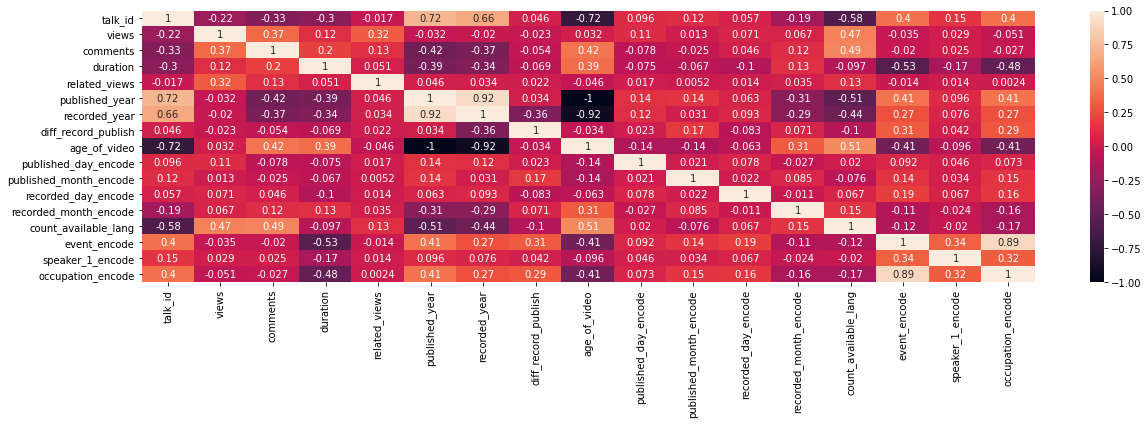

In [ ]:
sns.heatmap(df.corr(),annot= True)

## We can remove occupation and event:

1. They are highly correlated to each other

2. Not much relationship with the views.

In [ ]:
df.drop(columns=['event_encode','occupation_encode'],inplace= True)

## Remove published and recorded year due to following reasons:

1. Very highly correlated to one another and closely to some other variables.

2. Not much relationship with views.

In [ ]:
df.drop(columns=['published_year','recorded_year'],inplace= True)

# Let us visualize the most spoken about topics in the Ted talks :

In [ ]:
from wordcloud import WordCloud,ImageColorGenerator

In [ ]:
text = " ".join(topic for topic in df.topics.astype(str))

In [ ]:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

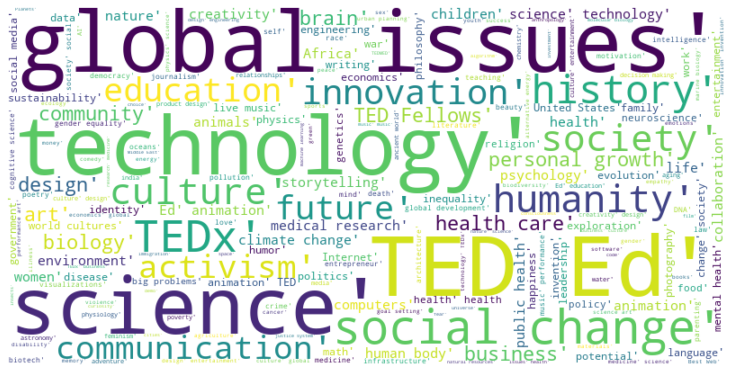

In [ ]:
plt.axis("off")

plt.rcParams["figure.figsize"] = (15,10)

plt.tight_layout(pad=0)

plt.imshow(wordcloud, interpolation='bilinear')

plt.savefig('/content/drive/MyDrive/Capstone Projects/Ted Talk Views Prediction/Data/Word cloud.png', dpi=300, bbox_inches='tight')

plt.show()

## There are two ways I am going to use topics column- 

1. Count the number of tags and make it into one feature

2. Segreagte the data according to different clusters by the most count of topics the talks were tagged in.

In [ ]:
#Raise the important top  topics first:

def define_topics(x):
  if 'TED Ed' in x:
    return 'TED Ed'
  elif 'global issues' in x:
    return 'global issues'
  elif 'technology' in x:
    return 'technology'
  elif 'science' in x:
    return 'science'
  elif 'social changes' in x:
    return 'social changes'
  elif 'communication' in x:
    return 'communication'
  elif 'business' in x:
    return 'business'
  elif 'history' in x:
    return 'history'
  elif 'art' in x:
    return 'art'
  else:
    return 'others'

In [ ]:
df['topic_cluster']= df['topics'].apply(define_topics)

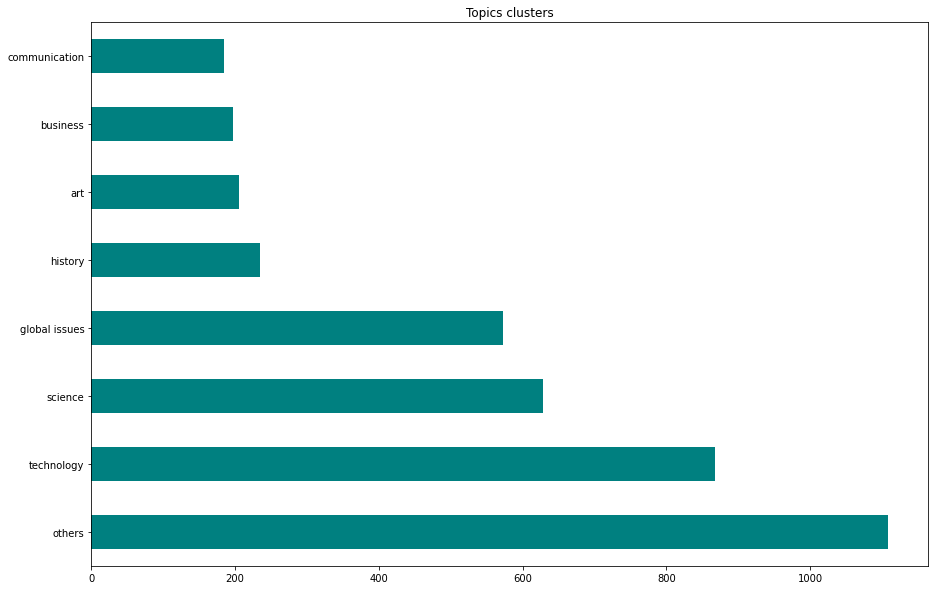

In [ ]:
df['topic_cluster'].value_counts().sort_values(ascending=False).plot(kind= 'barh',color= 'teal')

plt.title('Topics clusters')

plt.rcParams["figure.figsize"] = (10,7)

plt.savefig('/content/drive/MyDrive/Capstone Projects/Ted Talk Views Prediction/Data/topicscluster.png', dpi=300, bbox_inches='tight')

In [ ]:
df.columns

Index(['talk_id', 'title', 'about_speakers', 'views', 'comments', 'duration',
       'topics', 'related_talks', 'description', 'transcript', 'related_views',
       'diff_record_publish', 'age_of_video', 'published_day_encode',
       'published_month_encode', 'recorded_day_encode',
       'recorded_month_encode', 'count_available_lang', 'speaker_1_encode',
       'topic_cluster'],
      dtype='object')

In [ ]:
#Find the number of tags

def no_of_tags(x):
  return len(x)

In [ ]:
df['Num_tags']= df['topics'].apply(no_of_tags)

In [ ]:
df['Num_tags'].value_counts()

63     64
69     52
62     52
64     50
75     50
       ..
310     1
316     1
320     1
377     1
324     1
Name: Num_tags, Length: 287, dtype: int64

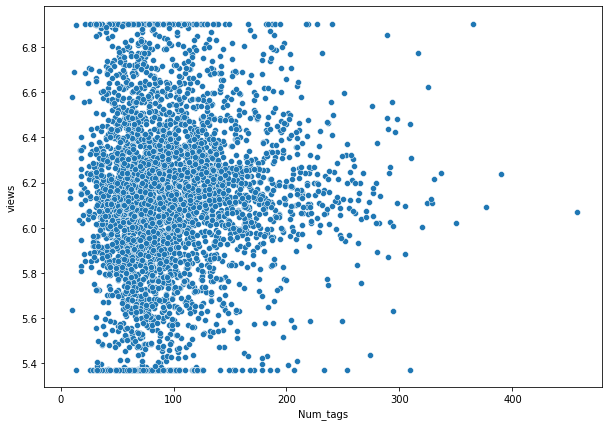

In [ ]:
sns.scatterplot(x= df['Num_tags'],y= df['views'])

# Feature selection by f-regression:

This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class.

This can only be used for numerical features and not string data.

In [ ]:
df['duration']= df['duration'].astype('float64')

In [ ]:
df.columns

Index(['talk_id', 'title', 'about_speakers', 'views', 'comments', 'duration',
       'topics', 'related_talks', 'description', 'transcript', 'related_views',
       'diff_record_publish', 'age_of_video', 'published_day_encode',
       'published_month_encode', 'recorded_day_encode',
       'recorded_month_encode', 'count_available_lang', 'speaker_1_encode',
       'topic_cluster', 'Num_tags'],
      dtype='object')

In [ ]:
num_var=['comments','duration','diff_record_publish','age_of_video','published_day_encode','published_month_encode','recorded_day_encode','recorded_month_encode',
         'count_available_lang','speaker_1_encode','Num_tags','related_views']

In [ ]:
numerical_features= df[num_var]

In [ ]:
dependent_variable= df['views']

In [ ]:
#import libraries

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [ ]:
f_scores = f_regression(numerical_features, dependent_variable)
f_scores

(array([6.51972054e+02, 5.71859110e+01, 2.05451740e+00, 4.15892622e+00,
        1.69606593e+01, 6.74087710e-01, 2.00471030e+01, 1.78009147e+01,
        1.12372854e+03, 3.29421826e+00, 1.23356786e+01, 5.50292348e+02]),
 array([2.39776213e-133, 4.88989081e-014, 1.51833545e-001, 4.14812902e-002,
        3.89340349e-005, 4.11679030e-001, 7.76653708e-006, 2.50705848e-005,
        2.48989865e-217, 6.95991131e-002, 4.49298515e-004, 4.03099724e-114]))

In [ ]:
#The second array consists of p-values that we need

p_values= pd.Series(f_scores[1],index= numerical_features.columns)

Text(0.5, 1.0, 'P-value scores for numerical features')

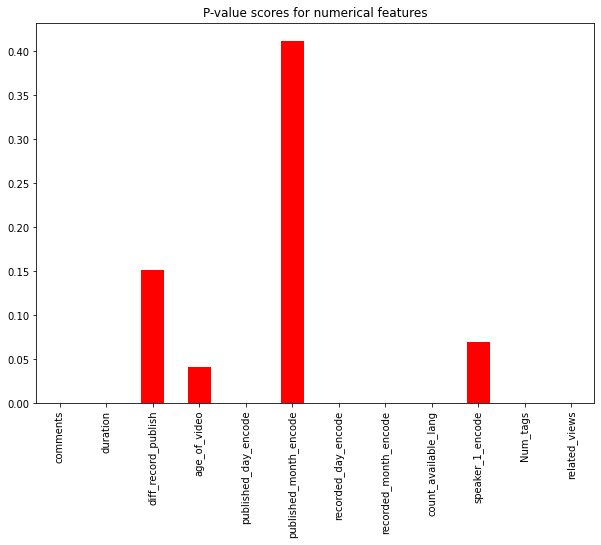

In [ ]:
p_values.plot(kind='bar',color='red')

plt.title('P-value scores for numerical features')

Remove the diff_record_publish column for high p values.

In [ ]:
df.head(2)

talk_id                            title  ...  topic_cluster  Num_tags
0        1      Averting the climate crisis  ...  global issues     134.0
1       92  The best stats you've ever seen  ...  global issues     138.0

[2 rows x 21 columns]

In [ ]:
numerical_features.drop(columns=['diff_record_publish','published_month_encode'],inplace= True)

In [ ]:
numerical_features.head(2)

comments  duration  age_of_video  ...  speaker_1_encode  Num_tags  related_views
0  0.042177  0.237442            15  ...          0.001000     134.0      1659584.0
1  0.059777  0.292595            15  ...          0.002501     138.0      1573950.0

[2 rows x 10 columns]

In [ ]:
dependent_variable.head(2)

0    6.546961
1    6.903742
Name: views, dtype: float64

In [ ]:
Q1 = numerical_features.quantile(0.25)
Q3 = numerical_features.quantile(0.75)
IQR = Q3 - Q1

((numerical_features < (Q1 - 1.5 * IQR)) | (numerical_features > (Q3 + 1.5 * IQR))).sum()

comments                   0
duration                   0
age_of_video               0
published_day_encode       0
recorded_day_encode        0
recorded_month_encode      0
count_available_lang       0
speaker_1_encode         335
Num_tags                   0
related_views              0
dtype: int64

In [ ]:
# Replacing outliers with extreme values

for i in numerical_features.columns:
  Q1 = numerical_features[i].quantile(0.25)
  Q3 = numerical_features[i].quantile(0.75)
  IQR = Q3 - Q1

  numerical_features[i]=np.where(numerical_features[i]<(Q1 - 1.5 * IQR),(Q1 - 1.5 * IQR),np.where(numerical_features[i]>(Q3 + 1.5 * IQR),(Q3 + 1.5 * IQR),numerical_features[i]))

In [ ]:
Q1 = numerical_features.quantile(0.25)
Q3 = numerical_features.quantile(0.75)
IQR = Q3 - Q1

((numerical_features < (Q1 - 1.5 * IQR)) | (numerical_features > (Q3 + 1.5 * IQR))).sum()

comments                 0
duration                 0
age_of_video             0
published_day_encode     0
recorded_day_encode      0
recorded_month_encode    0
count_available_lang     0
speaker_1_encode         0
Num_tags                 0
related_views            0
dtype: int64

In [ ]:
X= numerical_features

y= dependent_variable

In [ ]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train.columns

Index(['comments', 'duration', 'age_of_video', 'published_day_encode',
       'recorded_day_encode', 'recorded_month_encode', 'count_available_lang',
       'speaker_1_encode', 'Num_tags', 'related_views'],
      dtype='object')

# Checking in a simple XGBoost Baseline model with hyper paramater tuning first:

In [ ]:
from xgboost import XGBRegressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#XGBoost Regressor

# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the XGBoost
xgb_model = XGBRegressor(learning_rate=0.1)

#RandomSearch
xgb_random = RandomizedSearchCV(xgb_model,param_dict,verbose=2,cv=5)


xgb_random.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[04:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=4, total=   0.2s
[CV] n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[04:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=4, total=   0.1s
[CV] n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[04:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=4, total=   0.1s
[CV] n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[04:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=4, total=   0.1s
[CV] n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[04:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=4, total=   0.1s
[CV] n

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [ ]:
#The best esitmators
xgb_random.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, min_samples_leaf=50,
             min_samples_split=50, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [ ]:
#Building optimal model on the best estimators
xgb_optimal_model = xgb_random.best_estimator_

In [ ]:
print(f'r_sqr value for train: {xgb_optimal_model.score(X_train, y_train)}')

r_sqr value for train: 0.8299281011291281


Scores:

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [ ]:
# make predictions for test data
y_hat = xgb_optimal_model.predict(X_test)

# Calculate R-squared
r_squared= r2_score(y_test,y_hat)

#Calculate Adjusted R-sqaured
adjusted_r_squared = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print(f'The R_Squared for XGBoost is {r_squared} for train and adjusted R_Squared is {adjusted_r_squared}')


The R_Squared for XGBoost is 0.545632968449359 for train and adjusted R_Squared is 0.5444936328637255


In [ ]:
mse= mean_squared_error(y_test,y_hat)

In [ ]:
xgb_optimal_model.predict(X_test)[:20]

array([6.483085 , 6.5587163, 6.303705 , 6.1412597, 6.222139 , 6.187031 ,
       6.1337223, 6.0727625, 6.250952 , 6.1775217, 5.9435472, 5.968389 ,
       6.278824 , 5.992122 , 6.346162 , 6.5200844, 6.095921 , 6.119878 ,
       6.2589684, 6.6786504], dtype=float32)

In [ ]:
# Mean of testing data
np.sqrt(mean_squared_error(10**y_test,10**(xgb_optimal_model.predict(X_test))))

1229928.572064434

In [ ]:
(10**y_test).std()

1666286.4380951

In [ ]:
# Standard deviation is pretty high
np.array(10**y_test).std()

1665453.0864860395

1. Number of languages
2. Time taken to publish the video.
3. Number of speakers
4. Number of Occupations
5. How many talks that speaker has given prior to this
6. cluster label
7. From topic column we can find out top 10 topics and can use one hat encoding 
8. We can use point number 8 for speaker column as well.
9. Planning to cluster transcript+related talks, then we could built different models.


In [ ]:
df.head()

talk_id                            title  ...  topic_cluster  Num_tags
0        1      Averting the climate crisis  ...  global issues       134
1       92  The best stats you've ever seen  ...  global issues       138
2        7                 Simplicity sells  ...     technology       123
3       53              Greening the ghetto  ...       business       116
4       66      Do schools kill creativity?  ...         others        84

[5 rows x 21 columns]

## challenge-1
###How to induce impact of speaker columns on prediction

In [ ]:
df['related_talks'][4]

{865: 'Bring on the learning revolution!',
 1738: "How to escape education's death valley",
 2182: 'How to run a company with (almost) no rules',
 2276: 'How to fix a broken school? Lead fearlessly, love hard',
 2341: "Why some of us don't have one true calling",
 9048: 'The search for "aha!" moments'}

In [ ]:
df['description'][4]

'Sir Ken Robinson makes an entertaining and profoundly moving case for creating an education system that nurtures (rather than undermines) creativity.'

In [ ]:
len(df['transcript'][4])

17558

# New way

In [ ]:
gf=pd.read_csv("/content/drive/MyDrive/Capstone Projects/Ted Talk Views Prediction/Data/data_ted_talks.csv")

In [ ]:
gf.head()

talk_id  ...                                         transcript
0        1  ...  Thank you so much, Chris. And it's truly a gre...
1       92  ...  About 10 years ago, I took on the task to teac...
2        7  ...  (Music: "The Sound of Silence," Simon & Garfun...
3       53  ...  If you're here today — and I'm very happy that...
4       66  ...  Good morning. How are you? (Audience) Good. It...

[5 rows x 19 columns]

In [ ]:
gf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         4005 non-null   int64  
 1   title           4005 non-null   object 
 2   speaker_1       4005 non-null   object 
 3   all_speakers    4001 non-null   object 
 4   occupations     3483 non-null   object 
 5   about_speakers  3502 non-null   object 
 6   views           4005 non-null   int64  
 7   recorded_date   4004 non-null   object 
 8   published_date  4005 non-null   object 
 9   event           4005 non-null   object 
 10  native_lang     4005 non-null   object 
 11  available_lang  4005 non-null   object 
 12  comments        3350 non-null   float64
 13  duration        4005 non-null   int64  
 14  topics          4005 non-null   object 
 15  related_talks   4005 non-null   object 
 16  url             4005 non-null   object 
 17  description     4005 non-null   o

## Related talks

In [ ]:
#applying eval function on available_lang column
gf['related_talks'] = gf.apply(lambda row: eval(row['related_talks']), axis=1)

In [ ]:
#defining a new feature called related_views
gf['related_views'] = 0
#iterating through the each row and extracting the value of related_talks
for index, row in gf.iterrows():
    id_list=list(row['related_talks'].keys())
    temp=0
    for i in range(len(gf)):
      if (gf.loc[i,'talk_id']) in id_list:
        temp+=gf.loc[i,'views']

    gf.loc[index,'related_views']=temp//6

In [ ]:
nan_check(gf)

Total     %
comments          655  16.4
occupations       522  13.0
about_speakers    503  12.6
all_speakers        4   0.1
recorded_date       1   0.0
related_views       0   0.0
published_date      0   0.0
title               0   0.0
speaker_1           0   0.0
views               0   0.0
event               0   0.0
transcript          0   0.0
native_lang         0   0.0
available_lang      0   0.0
duration            0   0.0
topics              0   0.0
related_talks       0   0.0
url                 0   0.0
description         0   0.0
talk_id             0   0.0

In [ ]:
# pf=gf.dropna()
pf=gf.copy()

In [ ]:
pf.head(1)

talk_id  ... related_views
0        1  ...       1659584

[1 rows x 20 columns]

In [ ]:
pf['about_speakers'].head(2)

0    {0: 'Nobel Laureate Al Gore focused the world’...
1    {0: 'In Hans Rosling’s hands, data sings. Glob...
Name: about_speakers, dtype: object

In [ ]:
pf.columns

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript', 'related_views'],
      dtype='object')

In [ ]:
pf['views'].max()

65051954

## Event

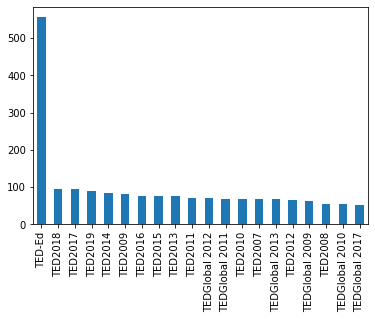

In [ ]:
pf['event'].value_counts().sort_values(ascending= False).head(20).plot(kind= 'bar')

In [ ]:
# One hat encoding, when TED-Ed=1,otherwise=0
pf['event']=np.where(pf['event']=='TED-Ed',1,0)

## Available language

In [ ]:
#applying eval function on available_lang column
pf['available_lang'] = pf.apply(lambda row: eval(row['available_lang']), axis=1)

pf['num_lang']=pf['available_lang'].apply(lambda x: len(x))

## Speaker_1

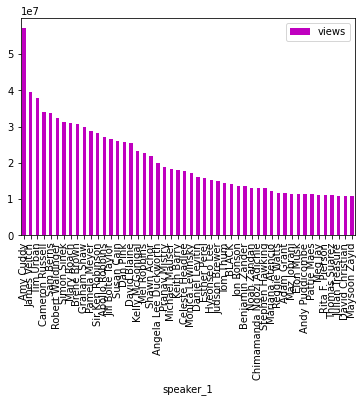

In [ ]:
pf.groupby(by='speaker_1').agg({'views' : 'mean'}).sort_values(by='views',ascending=False).head(50).plot(kind='bar',color='m')

### We will create one column where I will label encode it based upon views
### Target encoding for speaker_1

In [ ]:
pop_speaker=pf.groupby('speaker_1').agg({'views' : 'mean'}).sort_values(['views'],ascending=False)
pop_speaker=pop_speaker.to_dict()
pop_speaker=pop_speaker.values()
pop_speaker=  list(pop_speaker)[0]
pf['speaker_1']=pf['speaker_1'].map(pop_speaker)


### Keeping important features onnly

In [ ]:
req_feat=['event','num_lang','related_views','comments','duration','speaker_1']

req_X=pf[req_feat]
y=pf['views']


##Checking outliers in dataframe

In [ ]:
Q1 = pf.quantile(0.25)
Q3 = pf.quantile(0.75)
IQR = Q3 - Q1


((pf < (Q1 - 1.5 * IQR)) | (pf > (Q3 + 1.5 * IQR))).sum()

about_speakers      0
all_speakers        0
available_lang      0
comments          261
description         0
duration           21
event             556
native_lang         0
num_lang          121
occupations         0
published_date      0
recorded_date       0
related_talks       0
related_views     300
speaker_1         373
talk_id           119
title               0
topics              0
transcript          0
url                 0
views             393
dtype: int64

### Removing outliers in dataset by extreme values

In [ ]:
# Replacing outliers with extreme values

for i in ['views','comments','duration','event','num_lang','related_views','speaker_1']:
  Q1 = pf[i].quantile(0.25)
  Q3 = pf[i].quantile(0.75)
  IQR = Q3 - Q1

  pf[i]=np.where(pf[i]<(Q1 - 1.5 * IQR),(Q1 - 1.5 * IQR),np.where(pf[i]>(Q3 + 1.5 * IQR),(Q3 + 1.5 * IQR),pf[i]))
  # df[i]=np.where(df[i]>(Q3 - 1.5 * IQR),(Q3 + 1.5 * IQR),df[i])

In [ ]:
Q1 = pf.quantile(0.25)
Q3 = pf.quantile(0.75)
IQR = Q3 - Q1


((pf < (Q1 - 1.5 * IQR)) | (pf > (Q3 + 1.5 * IQR))).sum()

about_speakers      0
all_speakers        0
available_lang      0
comments            0
description         0
duration            0
event               0
native_lang         0
num_lang            0
occupations         0
published_date      0
recorded_date       0
related_talks       0
related_views       0
speaker_1           0
talk_id           119
title               0
topics              0
transcript          0
url                 0
views               0
dtype: int64

In [ ]:
nan_check(pf)

## Droping nan values.

In [ ]:
pf.dropna(inplace=True)

In [ ]:
len(pf)

3338

In [ ]:
pf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3338 entries, 0 to 4002
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         3338 non-null   int64  
 1   title           3338 non-null   object 
 2   speaker_1       3338 non-null   float64
 3   all_speakers    3338 non-null   object 
 4   occupations     3338 non-null   object 
 5   about_speakers  3338 non-null   object 
 6   views           3338 non-null   float64
 7   recorded_date   3338 non-null   object 
 8   published_date  3338 non-null   object 
 9   event           3338 non-null   float64
 10  native_lang     3338 non-null   object 
 11  available_lang  3338 non-null   object 
 12  comments        3338 non-null   float64
 13  duration        3338 non-null   float64
 14  topics          3338 non-null   object 
 15  related_talks   3338 non-null   object 
 16  url             3338 non-null   object 
 17  description     3338 non-null   o

In [ ]:
numerical_features=['comments','duration','event','num_lang','related_views','speaker_1']

In [ ]:
req_X=pf[numerical_features]

In [ ]:
y=pf['views']

Text(0.5, 1.0, 'P-value scores for numerical features')

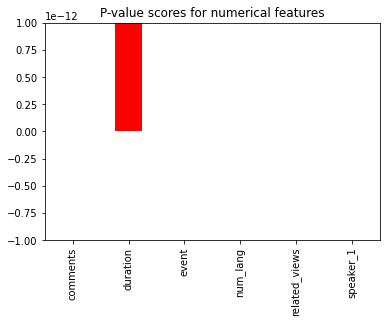

In [ ]:
f_scores = f_regression(req_X, y)
# f_scores

#The second array consists of p-values that we need

p_values= pd.Series(f_scores[1],index= req_X.columns)

p_values.plot(kind='bar',color='red')

plt.title('P-value scores for numerical features')

### Droping duration column

In [ ]:
req_X.drop(labels='duration',axis=1,inplace=True)

In [ ]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(req_X, y, test_size=0.25, random_state=42)

In [ ]:
#XGBoost Regressor

# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8,8,10,12,14,16]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the XGBoost
xgb_model = XGBRegressor(learning_rate=0.1)

#RandomSearch
xgb_random = RandomizedSearchCV(xgb_model,param_dict,verbose=2,cv=5)


xgb_random.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=4 
[12:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=4, total=   0.9s
[CV] n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=4 
[12:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=4, total=   0.1s
[CV] n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=4 
[12:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=4, total=   0.1s
[CV] n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=4 
[12:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=4, total=   0.1s
[CV] n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=4 
[12:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=4, total=   0.1s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=16 
[12:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=16, total=   0.2s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=16 
[12:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=16, total=   0.2s
[C

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [ ]:
# Training accuracy
print(f'r_sqr value for train: {xgb_optimal_model.score(X_train, y_train)}')

r_sqr value for train: 0.8985344838349151


In [ ]:
#Building optimal model on the best estimators
xgb_optimal_model = xgb_random.best_estimator_

# make predictions for test data
y_hat = xgb_optimal_model.predict(X_test)

# Calculate R-squared
r_squared= r2_score(y_test,y_hat)

#Calculate Adjusted R-sqaured
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-req_X.shape[1]-1)
print(f'The R_Squared for XGBoost is {r_squared} for train and adjusted R_Squared is {adjusted_r_squared}')


The R_Squared for XGBoost is 0.8711743051901452 for train and adjusted R_Squared is 0.870980989321583


In [ ]:
mean_absolute_error(y_test,y_hat)

183158.80658682634

In [ ]:
#XGBoost Regressor

# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8,8,10,12,14,16]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the XGBoost
xgb_model = XGBRegressor(learning_rate=0.1,criterion='mae')

#RandomSearch
xgb_random = RandomizedSearchCV(xgb_model,param_dict,verbose=2,cv=5)


xgb_random.fit(X_train,y_train)


# Training accuracy
print(f'r_sqr value for train: {xgb_optimal_model.score(X_train, y_train)}')


#Building optimal model on the best estimators
xgb_optimal_model = xgb_random.best_estimator_

# make predictions for test data
y_hat = xgb_optimal_model.predict(X_test)

# Calculate R-squared
r_squared= r2_score(y_test,y_hat)

#Calculate Adjusted R-sqaured
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-req_X.shape[1]-1)
print(f'The R_Squared for XGBoost is {r_squared} for train and adjusted R_Squared is {adjusted_r_squared}')

print(mean_absolute_error(y_test,y_hat))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[12:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[12:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[12:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=100, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[12:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=100, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[12:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=100, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   0.2s

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.3s finished


## Results are pretty impresssive.
### MAE is very less and R_squared is approx 87%.

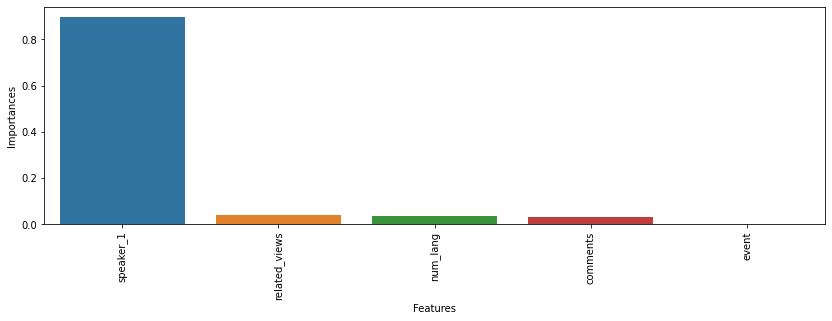

In [ ]:
importances = pd.DataFrame({'Features': req_X.columns, 
                                'Importances': xgb_optimal_model.feature_importances_})
    
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)
fig = plt.figure(figsize=(14, 4))
sns.barplot(x='Features', y='Importances', data=importances)
plt.xticks(rotation='vertical')
plt.show()

##**Let's try ExtraTreesRegressor.**

In [ ]:
#ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics

# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8,8,10,12,14,16]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the XGBoost
et_model = ExtraTreesRegressor(criterion='mae')

#RandomSearch
et_model = RandomizedSearchCV(et_model,param_dict,verbose=2,cv=5)


et_model.fit(X_train,y_train)



#Building optimal model on the best estimators
et_model = et_model.best_estimator_

#  make predictions for train data
y_hat_prob=et_model.predict(X_train)

# make predictions for test data
y_hat = et_model.predict(X_test)


# Calculate R-squared
r_squared= r2_score(y_test,y_hat)

#Calculate Adjusted R-sqaured
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-req_X.shape[1]-1)
print(f'The R_Squared for ExtraTrees is {r_squared} for train and adjusted R_Squared is {adjusted_r_squared}')



# printing training MAE
print('Train MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_hat_prob)))

# print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_hat)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   3.1s
[CV] n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV]  n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   3.1s
[CV] n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[CV]  n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   3.1s
[CV] n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[CV]  n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   3.0s
[CV] n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[CV]  n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   3.0s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=16 
[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=16, total=   2.0s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=16 
[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=16, total=   1.9s
[CV] n_estimators=50, min_samples_spl

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.7min finished


The R_Squared for ExtraTrees is 0.8398450915421733 for train and adjusted R_Squared is 0.839604763048089
Train MAE: 161360.62
Test MAE: 160207.14


## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor




rf = RandomForestRegressor(criterion='mae',max_depth=15, max_features=5, n_estimators=40)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))
# print('Views mean: {:0.2f}'.format(views.mean()))
# print('Views std: {:0.2f}'.format(views.std()))
y_test.mean()

Training MAE: 99557.37
Test MAE: 195726.74


1653776.1934131735

In [ ]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8,8,10,12,14,16]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the XGBoost
rf_model = RandomForestRegressor(criterion='mae')

#RandomSearch
rf_model = RandomizedSearchCV(rf_model,param_dict,verbose=2,cv=5)


rf_model.fit(X_train,y_train)



#Building optimal model on the best estimators
rf_model = rf_model.best_estimator_

#  make predictions for train data
y_hat_prob=rf_model.predict(X_train)

# make predictions for test data
y_hat = rf_model.predict(X_test)


# Calculate R-squared
r_squared= r2_score(y_test,y_hat)

#Calculate Adjusted R-sqaured
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-req_X.shape[1]-1)
print(f'The R_Squared for ExtraTrees is {r_squared} for train and adjusted R_Squared is {adjusted_r_squared}')



# printing training MAE
print('Train MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_hat_prob)))

# print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_hat)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=6, total=   3.1s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=6, total=   3.1s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=6 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=6, total=   3.1s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=6 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=6, total=   3.2s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=6 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=6, total=   3.2s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=8 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=8, total=   3.2s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=8 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=8, total=   3.1s
[CV] n_estimators=100, min_samples_split=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.3min finished


The R_Squared for ExtraTrees is 0.8353182096680003 for train and adjusted R_Squared is 0.8350710881338886
Train MAE: 158401.51
Test MAE: 159809.78


# So far Extra Tree Regressor is the best performimg model.

## Let's try NLP for Clustering textual column

In [ ]:
#Text pre-processing
"""removes punctuation, stopwords, and returns a list of the remaining words, or tokens"""
import nltk
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')

# create an object of stemming function



import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    # stemmer1 = WordNetLemmatizer()

    stemmer = SnowballStemmer("english")

    # Removes punctuations
    nopunc = [char for char in text if char not in string.punctuation]

    # Removes numbers
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])

    # Removes stopwords

    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]

    # Stemming words
    
    nopunc = [stemmer.stem(word) for word in nopunc]

    return " ".join(nopunc)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
pf.head(1)

talk_id                        title  ...  related_views num_lang
0        1  Averting the climate crisis  ...        1659584       43

[1 rows x 21 columns]

### Merging column description and transcript

In [ ]:
pf['tokenized_message'] = pf['transcript'].apply(text_process)

In [ ]:
pf['tokenized_message'][1]

'about year ago i took task teach global develop swedish undergradu student that spent year togeth african institut studi hunger africa so i sort expect know littl world and i start medic univers karolinska institut undergradu cours call global health but get opportun get littl nervous i thought student come us actual highest grade get swedish colleg system i thought mayb know everyth im go teach so i pretest came and one question i learn lot one which countri highest child mortal five pair and i put togeth pair countri one twice child mortal and mean much bigger differ uncertainti data i wont put test turkey highest poland russia pakistan south africa and result swedish student i i got confid interv pretti narrow and i got happi cours — right answer five possibl that mean place professor intern health cours laughter but one late night i compil report i realli realiz discoveri i shown swedish top student know statist signific less world chimpanze laughter becaus chimpanze would score h

In [ ]:
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor=TfidfVectorizer(max_df=0.7,min_df=.01,ngram_range=(3,3))

In [ ]:
vect=vectorizor.fit_transform(pf['tokenized_message'])

In [ ]:
# collect the tfid matrix in numpy array
array = vect.toarray()

In [ ]:
# store the tf-idf array into pandas dataframe
X = pd.DataFrame(array)
X.head(10)

0         1         2     3     ...     4966      4967  4968  4969
0  0.00000  0.000000  0.000000   0.0  ...  0.00000  0.000000   0.0   0.0
1  0.00000  0.000000  0.015420   0.0  ...  0.00000  0.000000   0.0   0.0
2  0.00000  0.000000  0.000000   0.0  ...  0.00000  0.000000   0.0   0.0
3  0.03932  0.000000  0.000000   0.0  ...  0.02416  0.034201   0.0   0.0
4  0.00000  0.026433  0.000000   0.0  ...  0.00000  0.000000   0.0   0.0
5  0.00000  0.045960  0.015315   0.0  ...  0.00000  0.050216   0.0   0.0
6  0.00000  0.023084  0.015384   0.0  ...  0.00000  0.000000   0.0   0.0
7  0.00000  0.000000  0.007250   0.0  ...  0.00000  0.000000   0.0   0.0
8  0.00000  0.024685  0.000000   0.0  ...  0.00000  0.000000   0.0   0.0
9  0.00000  0.010492  0.034962   0.0  ...  0.00000  0.000000   0.0   0.0

[10 rows x 4970 columns]

### K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


import matplotlib.cm as cm


For n_clusters = 20 The average silhouette_score is : 0.014781926362565666
For n_clusters = 21 The average silhouette_score is : 0.014244990919565374
For n_clusters = 22 The average silhouette_score is : 0.011138957565060633
For n_clusters = 23 The average silhouette_score is : 0.013139930159215385
For n_clusters = 24 The average silhouette_score is : 0.011307022532395895
For n_clusters = 25 The average silhouette_score is : 0.011534102812666319
For n_clusters = 26 The average silhouette_score is : 0.014576025361897725
For n_clusters = 27 The average silhouette_score is : 0.014927613476137028
For n_clusters = 28 The average silhouette_score is : 0.01498926718249054
For n_clusters = 29 The average silhouette_score is : 0.013839389874290555


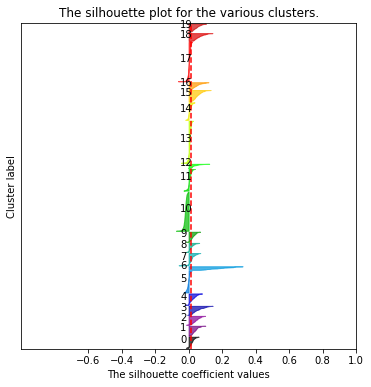

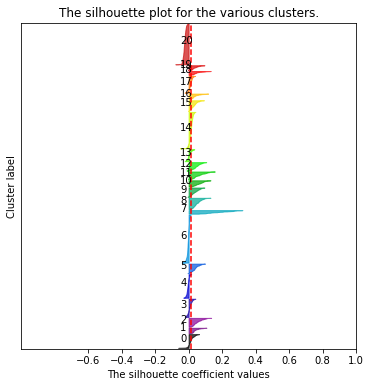

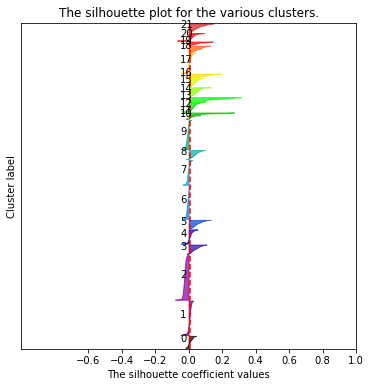

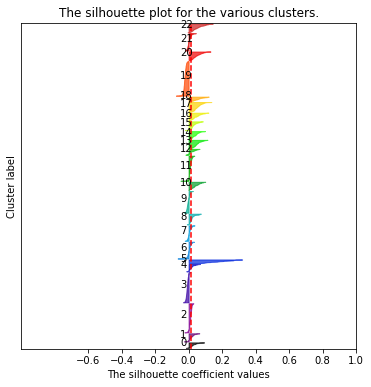

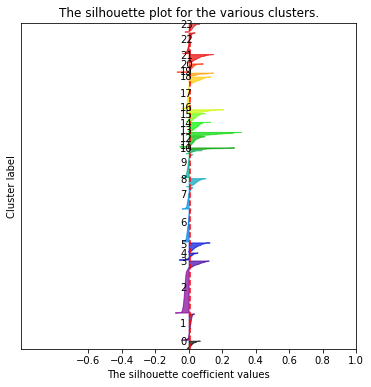

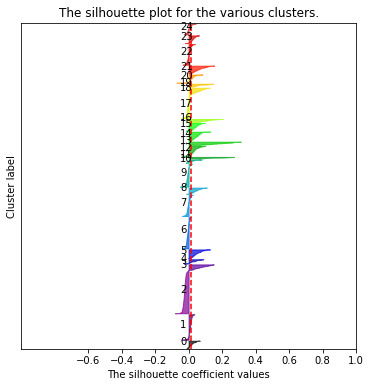

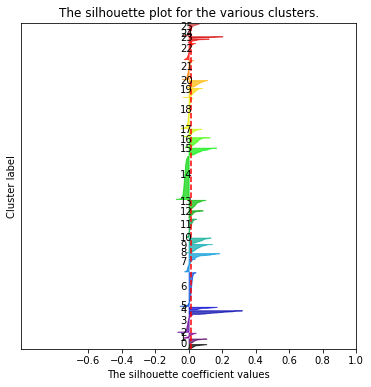

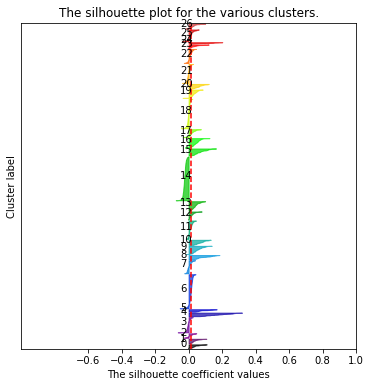

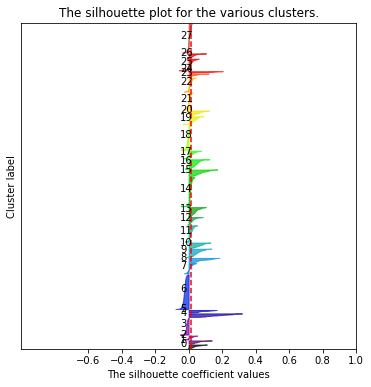

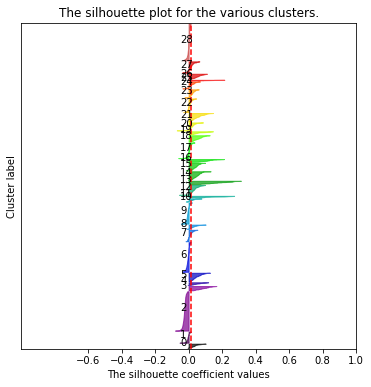

In [ ]:
# range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16,17,18,19,20]

for n_clusters in range(20,30,1):
    # Create a subplot with 1 row and 2 columns
    fig, (ax) = plt.subplots(1)
    fig.set_size_inches(6, 6)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


([<matplotlib.axis.XTick at 0x7fe91c912d10>,
 <a list of 12 Text major ticklabel objects>)

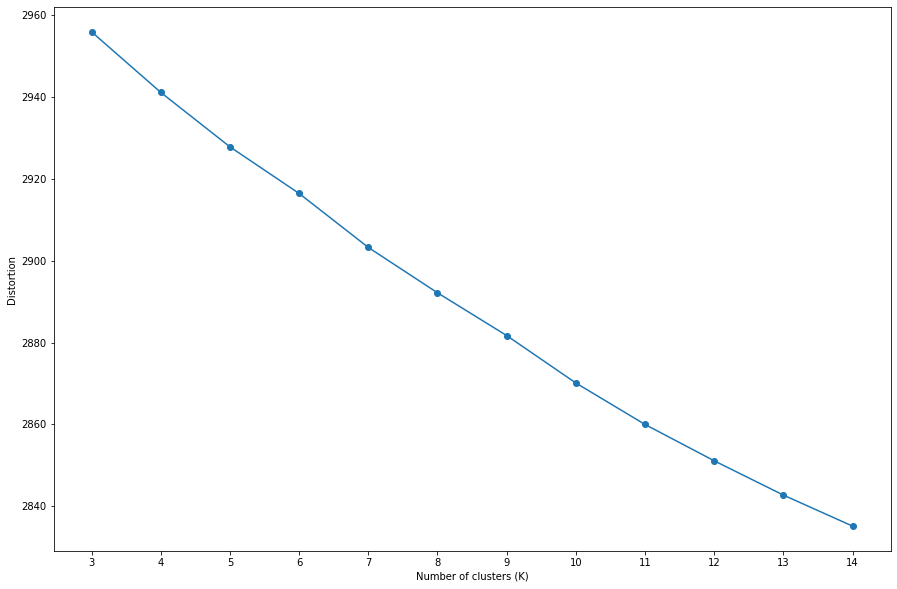

In [ ]:
distortions = []

for k in range(3, 15):
    KMeans_model = KMeans(n_clusters=k, random_state=42)
    KMeans_model.fit(X)
    distortions.append(KMeans_model.inertia_)

plt.plot(range(3, 15), distortions,  marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')
plt.xticks(range(3,15))

### Hierarchical Clustering

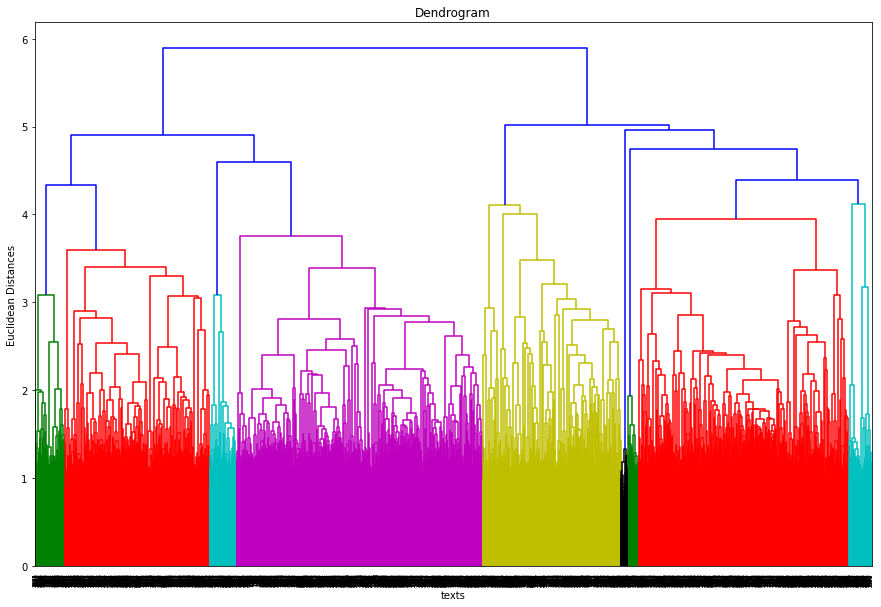

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10


# Using the dendogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('texts')
plt.ylabel('Euclidean Distances')
plt.show() # find largest vertical distance we can make without crossing any other horizontal line

### Visualising clusters

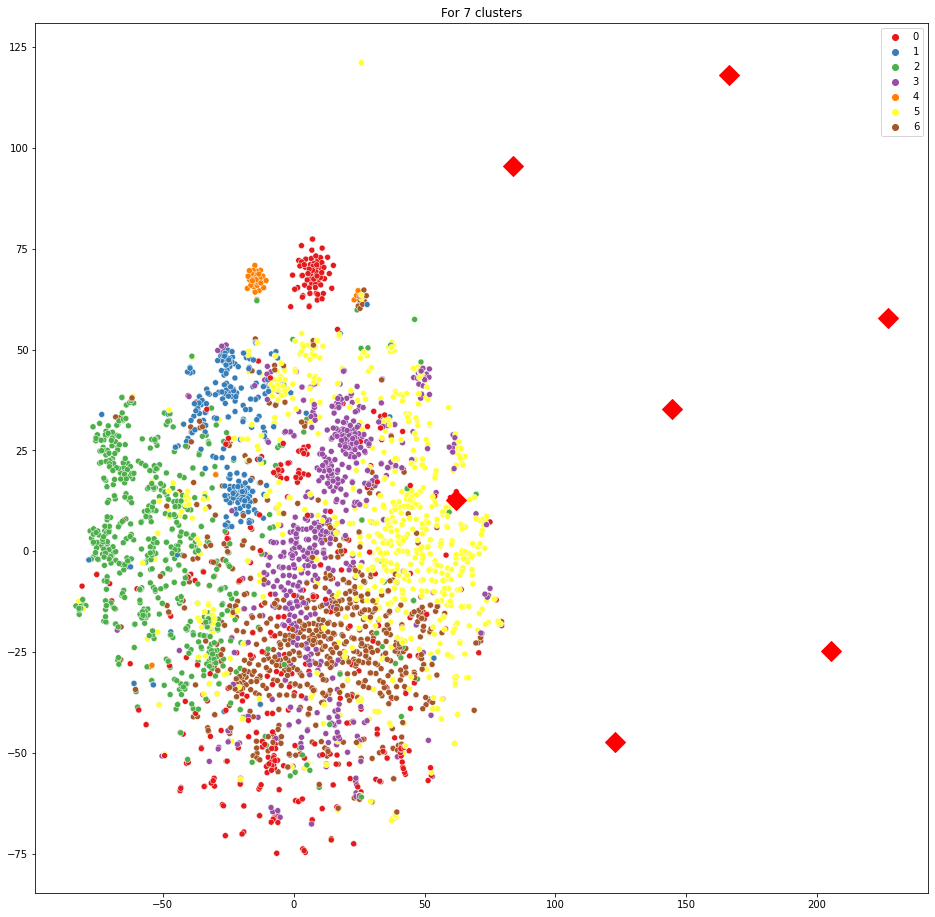

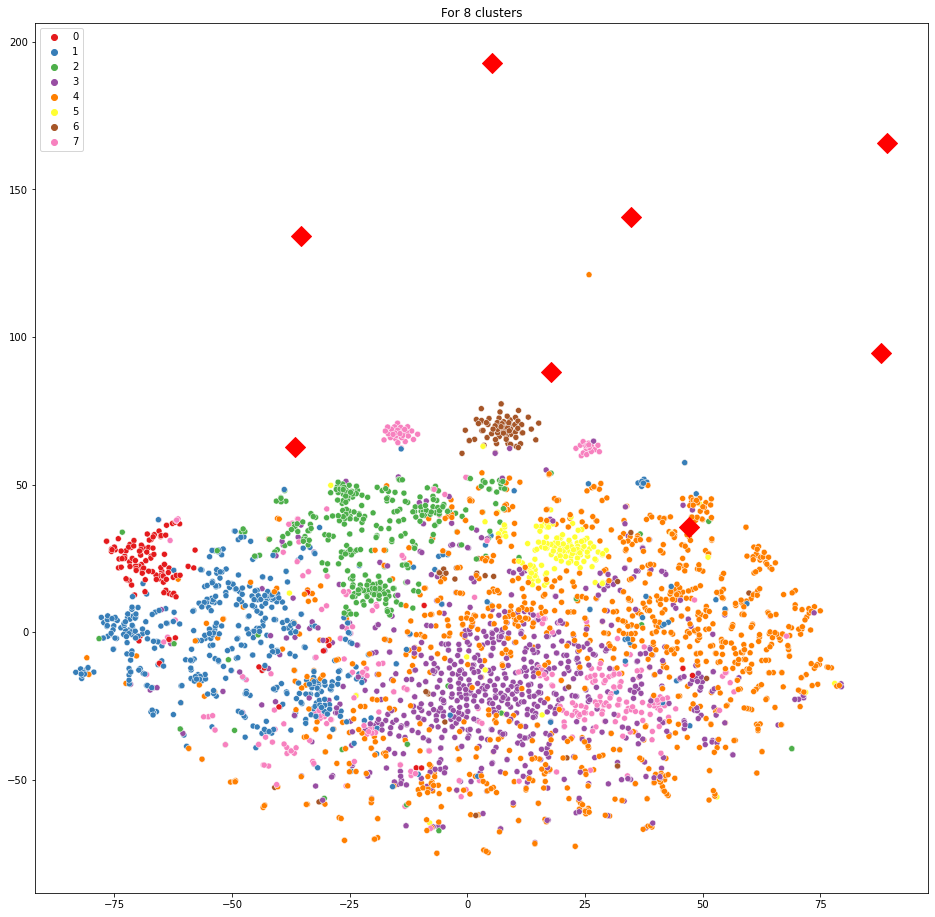

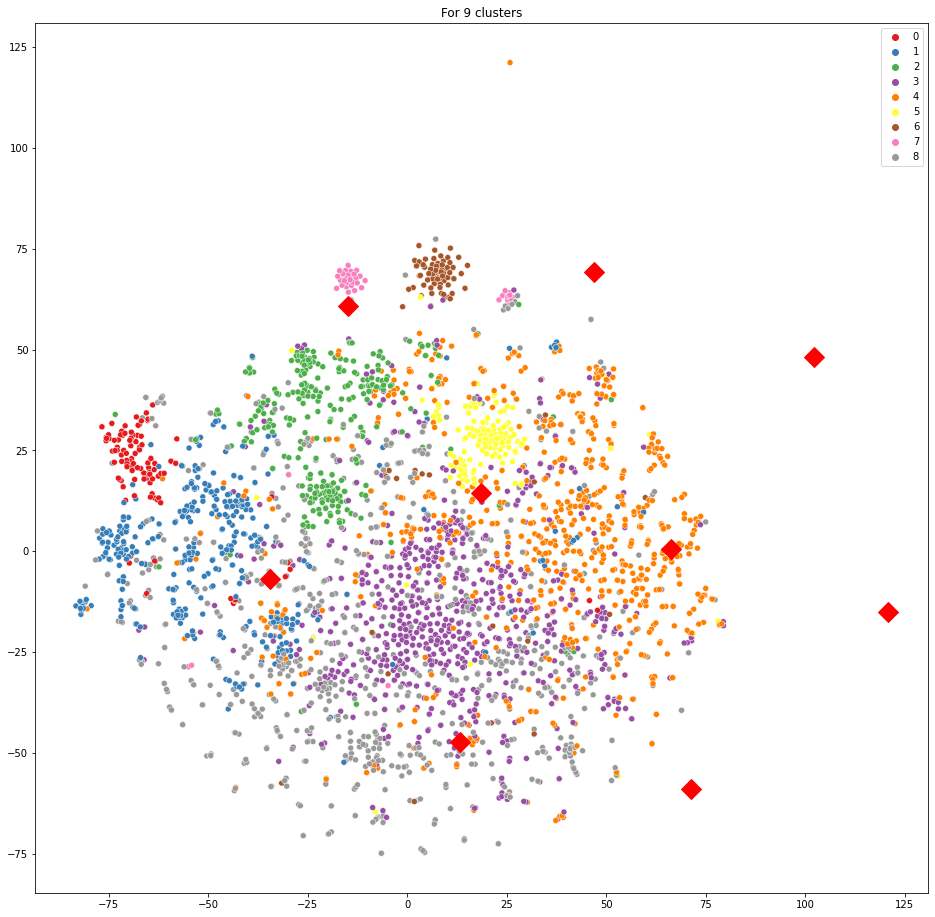

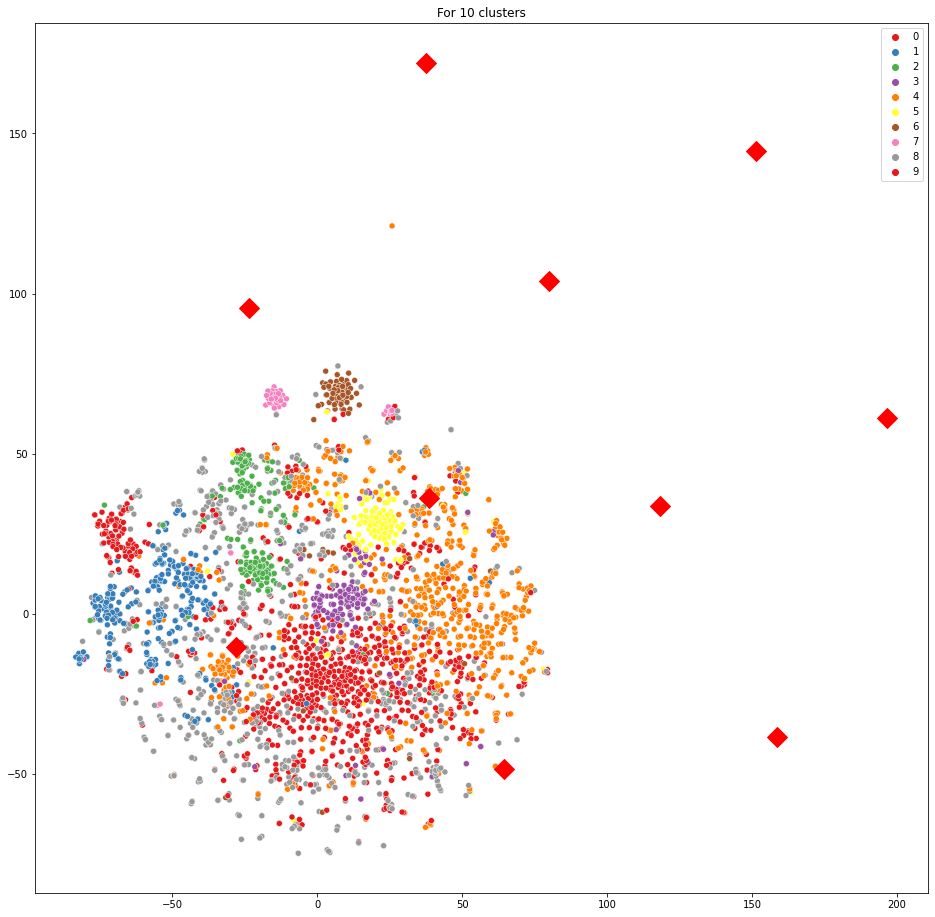

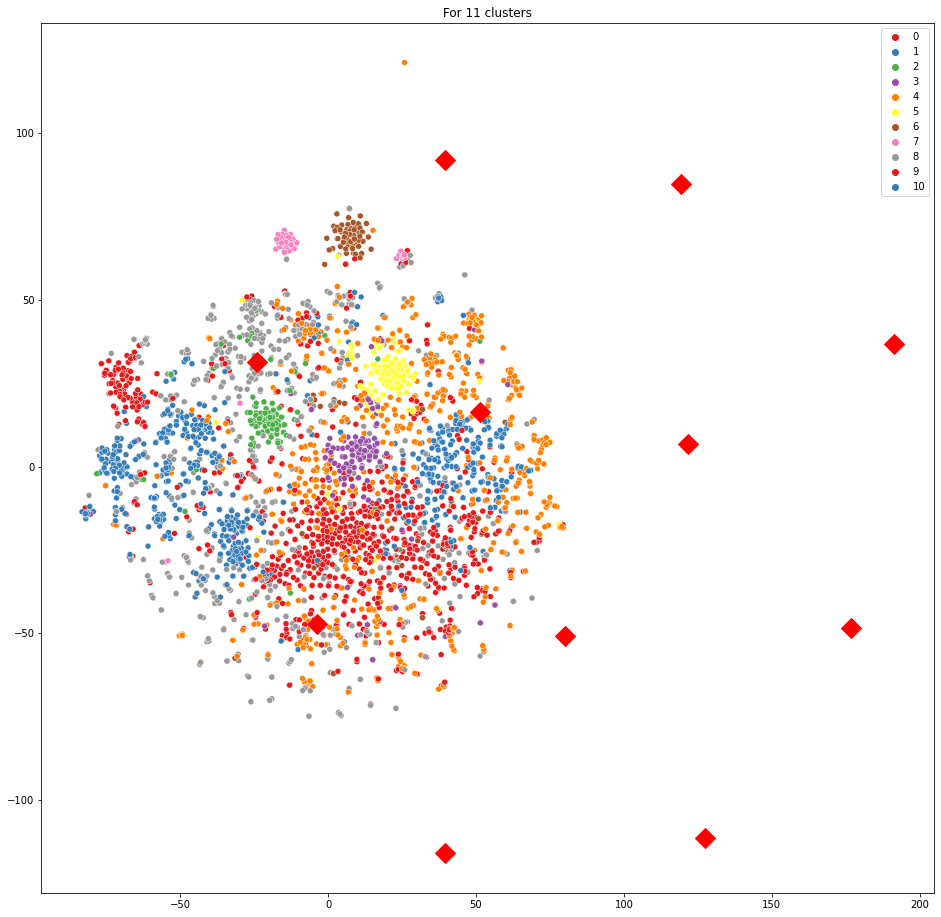

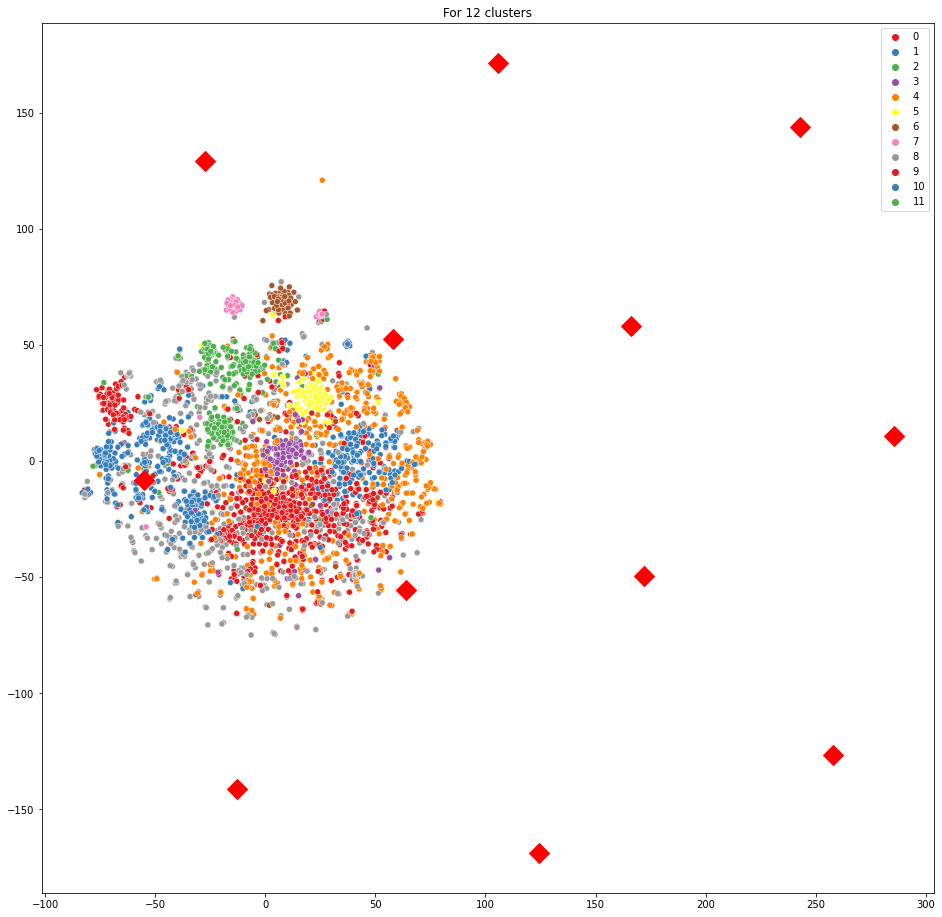

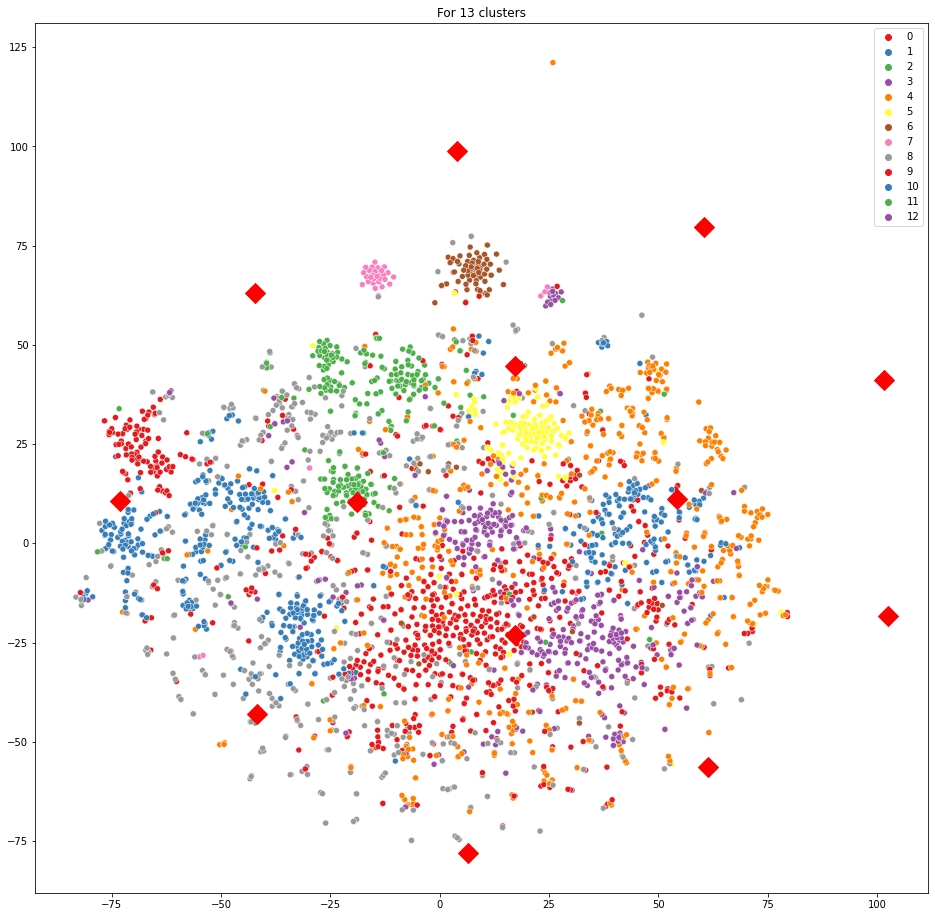

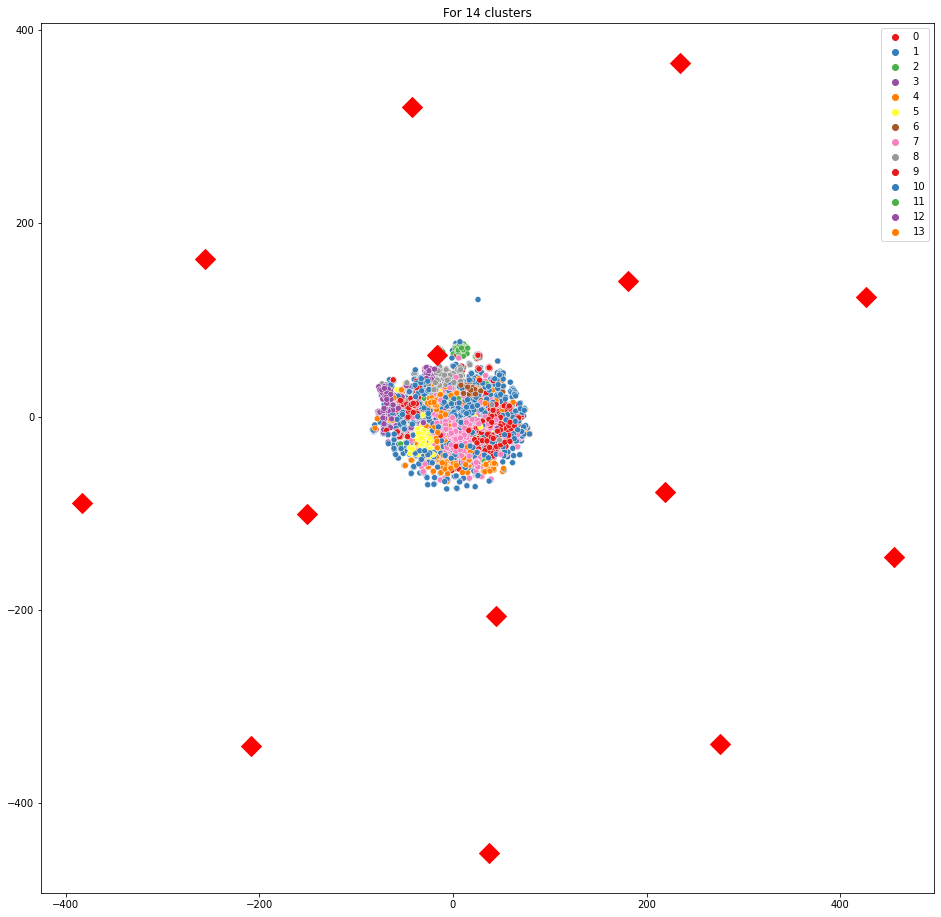

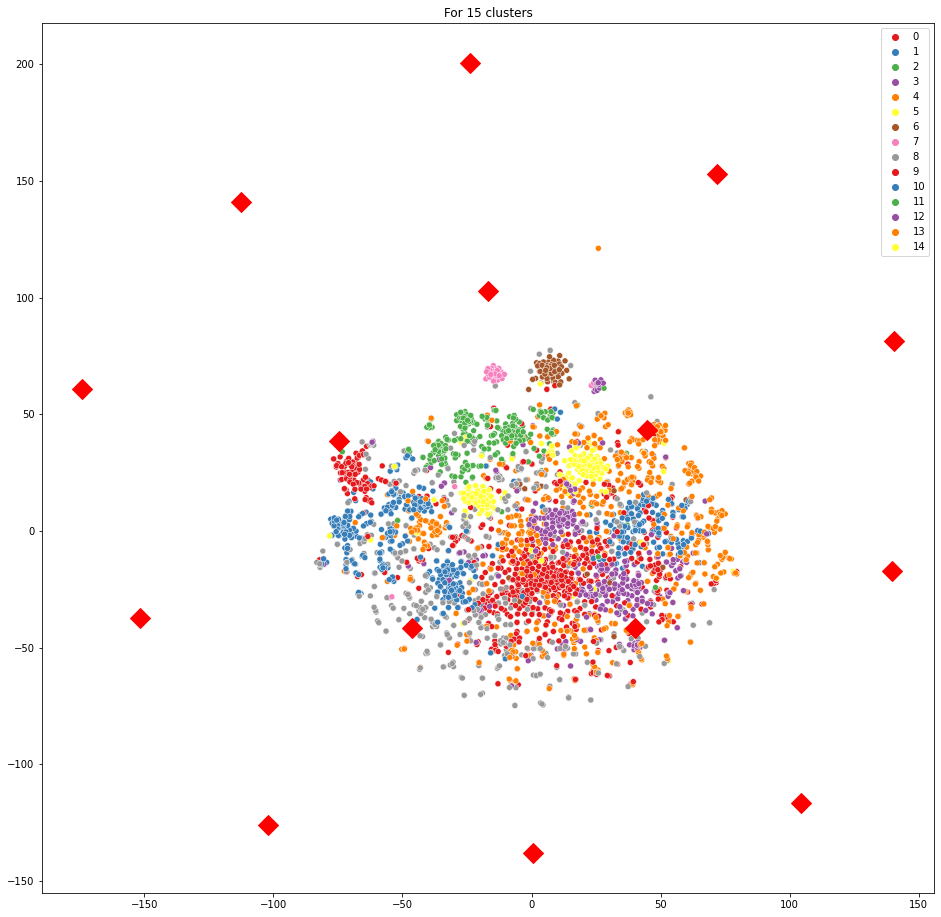

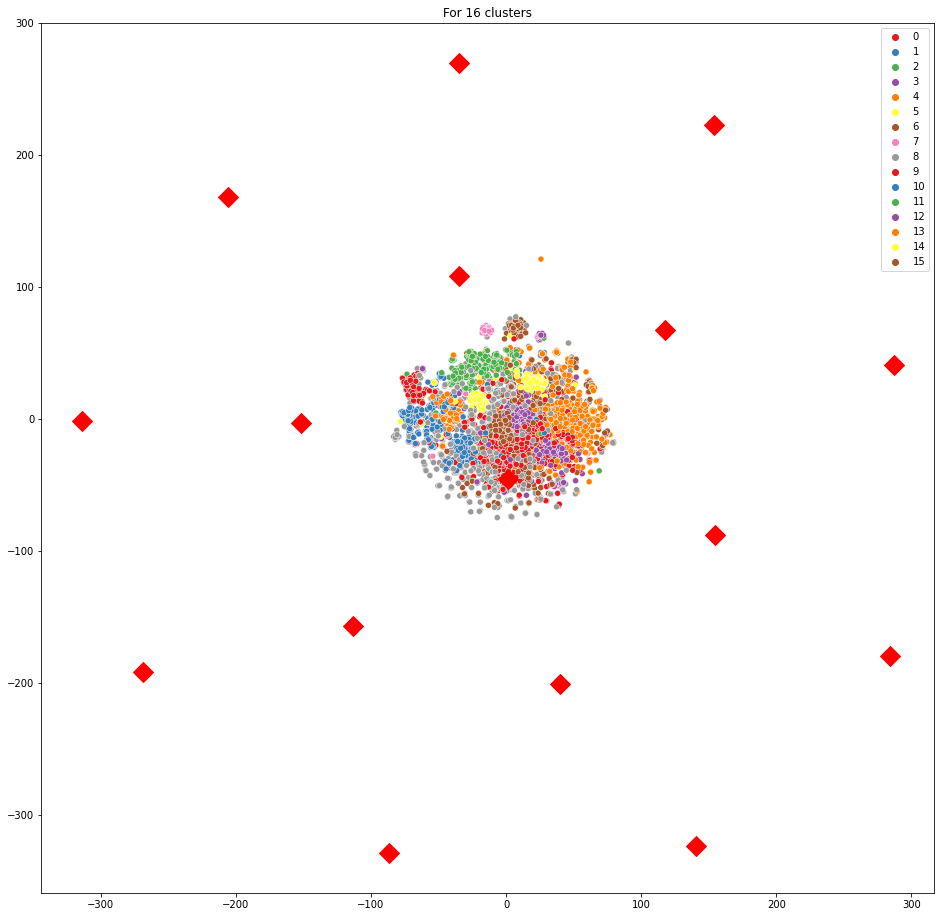

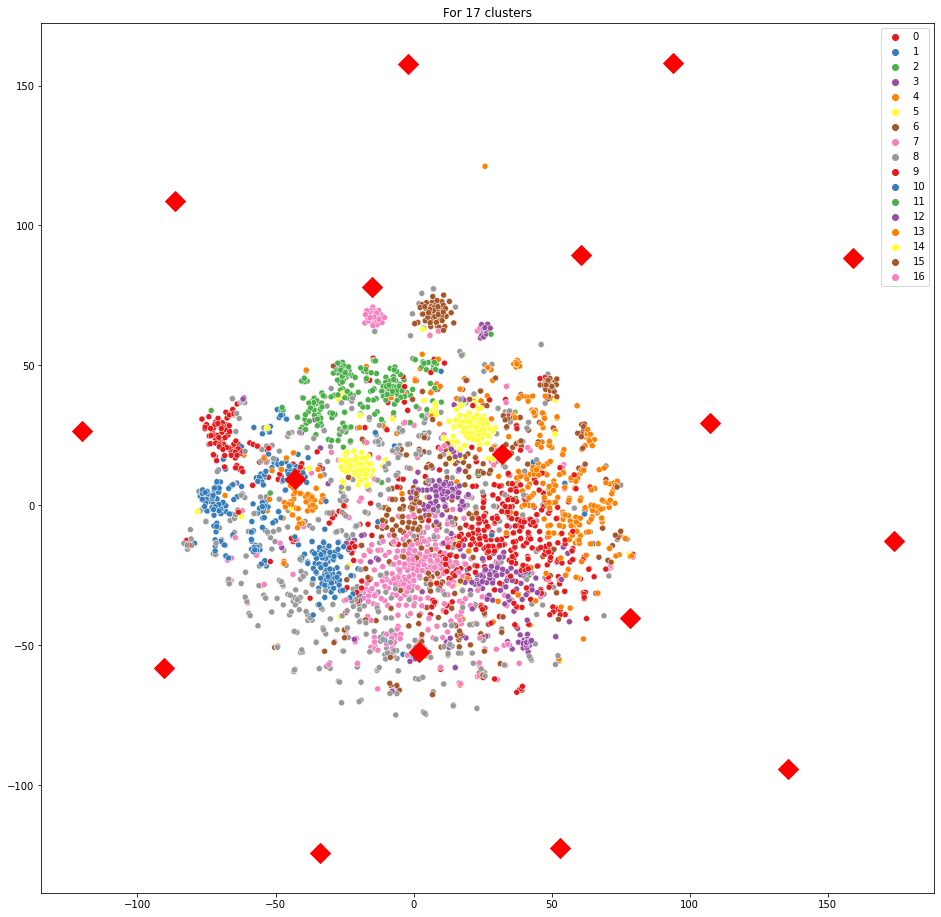

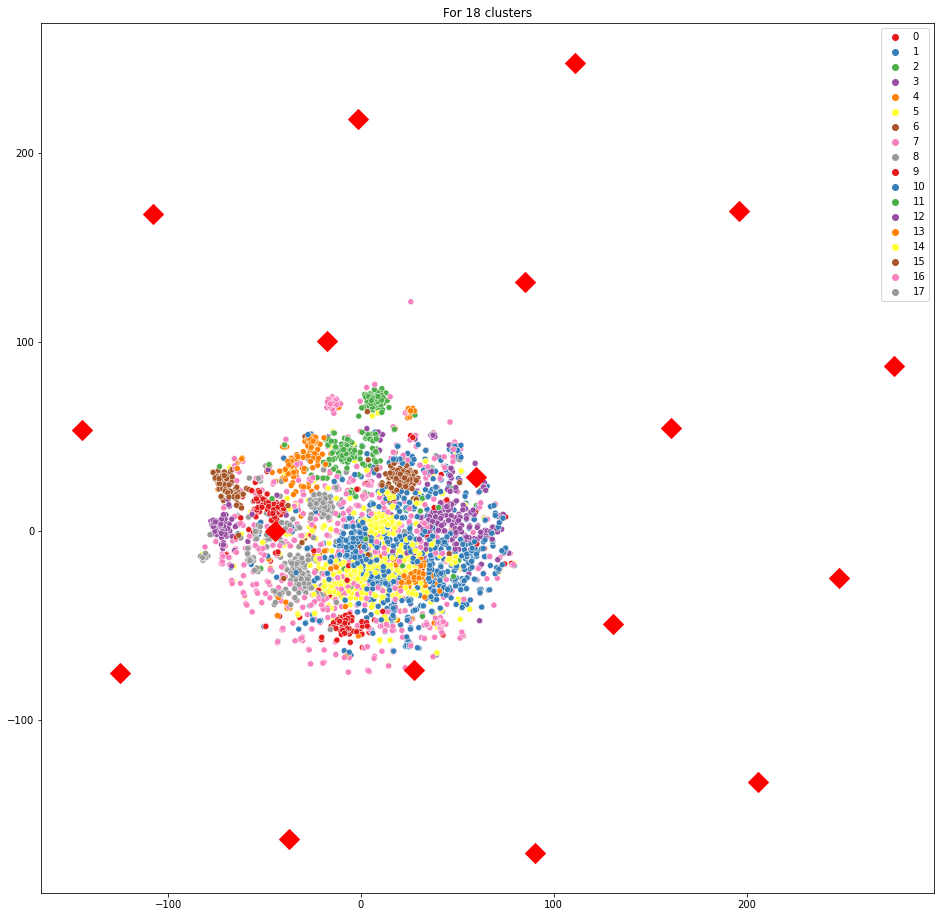

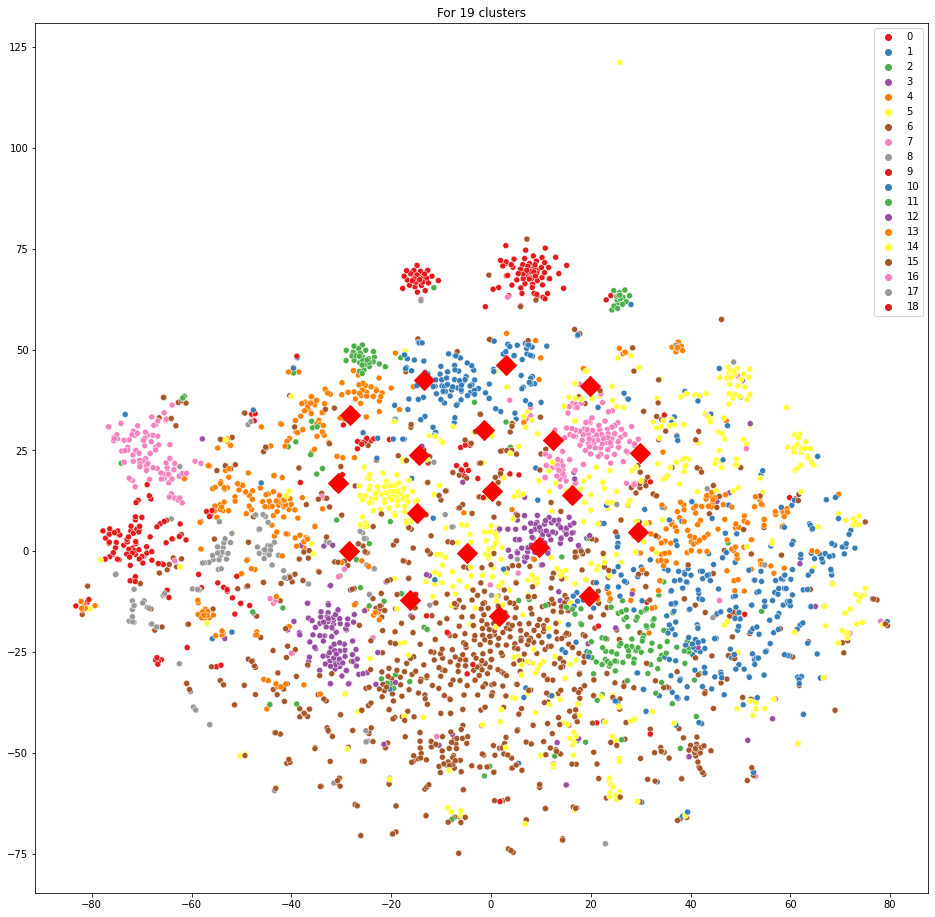

In [ ]:
for n in range(7,20):
  cls = KMeans(init="k-means++", n_clusters=n, random_state=10)
  cls.fit(X)

  reduced_cluster_centers = tsne_model.fit_transform(cls.cluster_centers_)
  plt.figure(figsize=(16, 16)) 
  sns.scatterplot(new_values[:,0],new_values[:,1],c=cls.predict(X),hue=cls.labels_, 
                  palette='Set1')
  plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='D',c='r',s=200)
  plt.title(f'For {n} clusters')
  plt.legend()
  plt.show()

# Clusters are not perfect, so we should not consider clustering approach.